# Анализ бизнес-показателей

Маркетинговый отдел развлекательного приложения Procrastinate Pro+ предоставил для анализа данные о сессиях новых пользователей, их покупках в приложении и затратах на рекламу в различных каналах продвижения с 1 мая по 27 октября 2019 года. Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки. Поставлена задача — разобраться в причинах и помочь компании выйти в плюс.

В ходе анализа предстоит изучить:
- откуда приходят пользователи и какими устройствами они пользуются,
- сколько стоит привлечение пользователей из различных рекламных каналов;
- сколько денег приносит каждый клиент,
- когда расходы на привлечение клиента окупаются,
- какие факторы мешают привлечению клиентов.

## Общая информация и предобработка данных

In [1]:
# импорт библиотек
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

In [2]:
# загрузка данных
visits = pd.read_csv('visits_info_short.csv')
orders = pd.read_csv('orders_info_short.csv')
costs = pd.read_csv('costs_info_short.csv')

# вывод первых срок для ознакомления
display(visits.head())
display(orders.head())
display(costs.head())

User Id         Region   Device  Channel        Session Start  \
0  981449118918  United States   iPhone  organic  2019-05-01 02:36:01   
1  278965908054  United States   iPhone  organic  2019-05-01 04:46:31   
2  590706206550  United States      Mac  organic  2019-05-01 14:09:25   
3  326433527971  United States  Android   TipTop  2019-05-01 00:29:59   
4  349773784594  United States      Mac  organic  2019-05-01 03:33:35   

           Session End  
0  2019-05-01 02:45:01  
1  2019-05-01 04:47:35  
2  2019-05-01 15:32:08  
3  2019-05-01 00:54:25  
4  2019-05-01 03:57:40

User Id             Event Dt  Revenue
0  188246423999  2019-05-01 23:09:52     4.99
1  174361394180  2019-05-01 12:24:04     4.99
2  529610067795  2019-05-01 11:34:04     4.99
3  319939546352  2019-05-01 15:34:40     4.99
4  366000285810  2019-05-01 13:59:51     4.99

dt   Channel  costs
0  2019-05-01  FaceBoom  113.3
1  2019-05-02  FaceBoom   78.1
2  2019-05-03  FaceBoom   85.8
3  2019-05-04  FaceBoom  136.4
4  2019-05-05  FaceBoom  122.1

In [3]:
# приведём названия столбцов датафреймов к стандартному виду
visits.columns = ['user_id', 'region', 'device', 'channel', 'session_start', 'session_end']
orders.columns = ['user_id', 'event_dt', 'revenue']
costs.columns = ['dt', 'channel', 'costs']

Выведем общую информацию о датафреймах:

In [4]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user_id        309901 non-null  int64 
 1   region         309901 non-null  object
 2   device         309901 non-null  object
 3   channel        309901 non-null  object
 4   session_start  309901 non-null  object
 5   session_end    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [5]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   40212 non-null  int64  
 1   event_dt  40212 non-null  object 
 2   revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [6]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


Пропуски во всех трёх датафреймах отсутствуют. Необходимо привести столбцы с датами и временем к форомату `datetime` для дальнейших операций с ними.

In [7]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

Проверим датафреймы на наличие дубликатов:

In [8]:
visits.duplicated().sum()

0

In [9]:
orders.duplicated().sum()

0

In [10]:
costs.duplicated().sum()

0

Явные полные дубликаты отсутствуют!

In [11]:
visits['region'].unique()

array(['United States', 'UK', 'France', 'Germany'], dtype=object)

In [12]:
visits['device'].unique()

array(['iPhone', 'Mac', 'Android', 'PC'], dtype=object)

In [13]:
visits['channel'].unique()

array(['organic', 'TipTop', 'RocketSuperAds', 'YRabbit', 'FaceBoom',
       'MediaTornado', 'AdNonSense', 'LeapBob', 'WahooNetBanner',
       'OppleCreativeMedia', 'lambdaMediaAds'], dtype=object)

In [14]:
costs['channel'].unique()

array(['FaceBoom', 'MediaTornado', 'RocketSuperAds', 'TipTop', 'YRabbit',
       'AdNonSense', 'LeapBob', 'OppleCreativeMedia', 'WahooNetBanner',
       'lambdaMediaAds'], dtype=object)

Неявные дубликаты в столбцах со строковым типом данных также отсутствуют.

Посмотрим на распределение значений числовых и временнЫх столбцов.

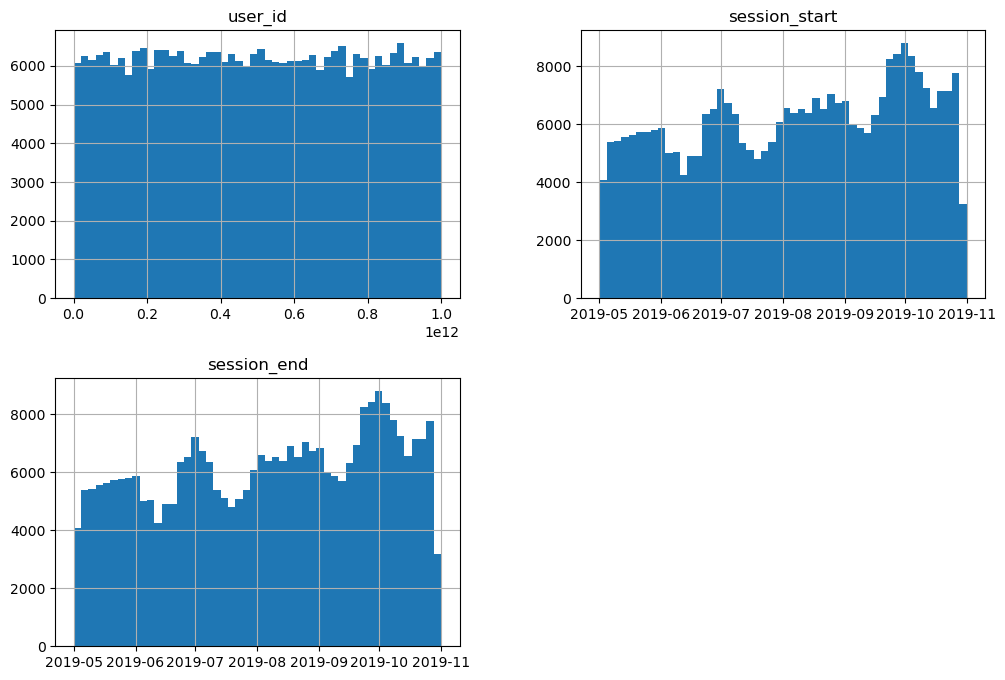

In [15]:
visits.hist(figsize=(12, 8), bins=50);

Число сессий постепенно растёт с течением времени.

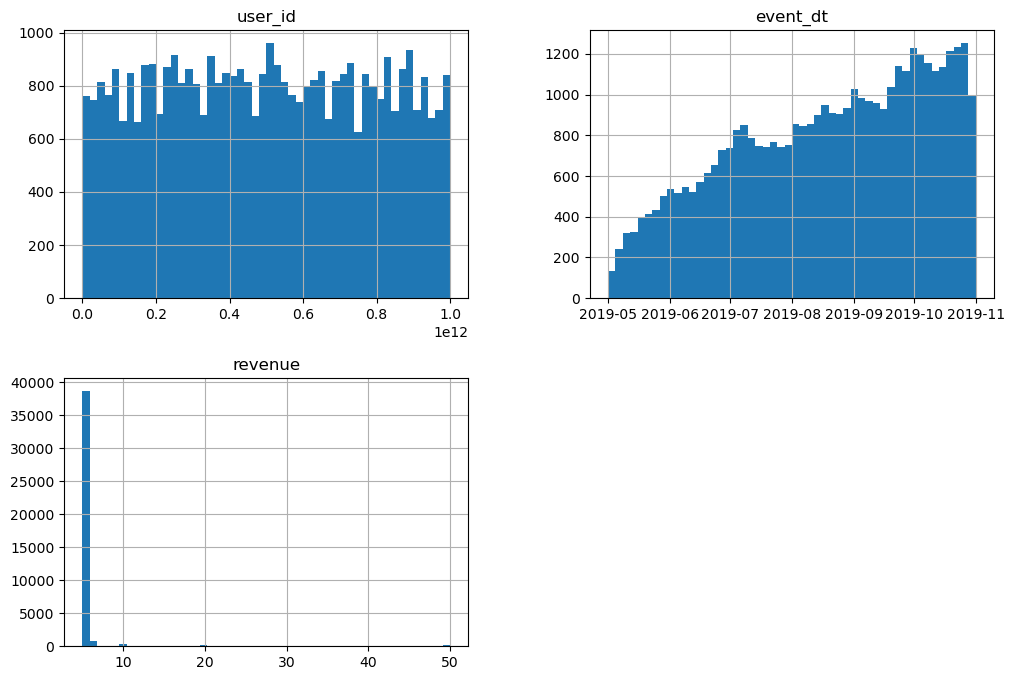

In [16]:
orders.hist(figsize=(12, 8), bins=50);

Постепенно растёт число покупок. Присутствует небольшое количество пользователей с особо крупными заказами. Всплеск суммы заказа в районе 0.

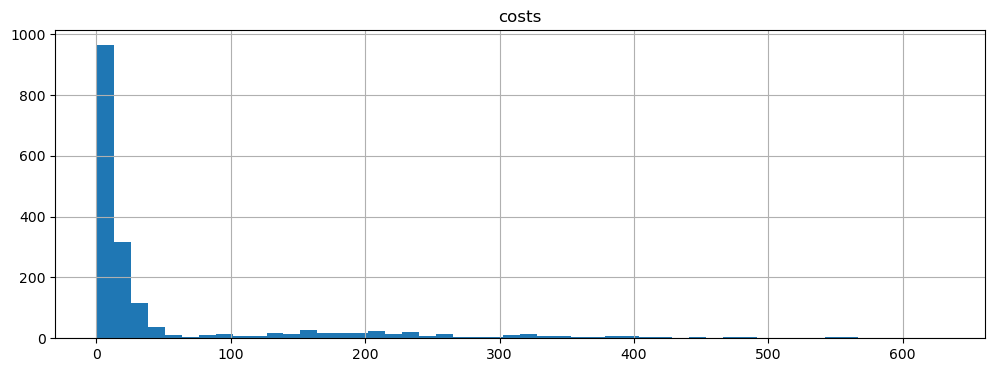

In [17]:
costs.hist(figsize=(12, 4), bins=50);

Всплеск затрат на рекламные кампании в районе 0, небольшое количество высоких затрат на рекламу.

## Функции для расчёта и анализа LTV, ROI, удержания и конверсии

In [18]:
# функция для создания профилей пользователей

def get_profiles(visits, orders, costs):

    # находим параметры первых посещений
    profiles = (
        visits.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    costs = costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    costs['acquisition_cost'] = costs['costs'] / costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [19]:
# функция для подсчёта Retention Rate

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [20]:
# функция для подсчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [21]:
# функция для подсчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time  # таблица динамики ROI
    )

In [22]:
# функция для сглаживания данных

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [23]:
# функция для построения графика Retention Rate

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [24]:
# функция для построения графика конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [25]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

## Исследовательский анализ данных

### Профили пользователей

Составим профили пользователей. Определим минимальную и максимальную даты привлечения пользователей.

In [26]:
# получаем профили пользователей
profiles = get_profiles(visits, orders, costs)
profiles.head(5)

user_id            first_ts     channel  device         region  \
0    599326 2019-05-07 20:58:57    FaceBoom     Mac  United States   
1   4919697 2019-07-09 12:46:07    FaceBoom  iPhone  United States   
2   6085896 2019-10-01 09:58:33     organic  iPhone         France   
3  22593348 2019-08-22 21:35:48  AdNonSense      PC        Germany   
4  31989216 2019-10-02 00:07:44     YRabbit  iPhone  United States   

           dt      month  payer  acquisition_cost  
0  2019-05-07 2019-05-01   True          1.088172  
1  2019-07-09 2019-07-01  False          1.107237  
2  2019-10-01 2019-10-01  False          0.000000  
3  2019-08-22 2019-08-01  False          0.988235  
4  2019-10-02 2019-10-01  False          0.230769

In [27]:
# минимальная дата привлечения пользователей
min_analysis_date = profiles['dt'].min()
min_analysis_date

datetime.date(2019, 5, 1)

In [28]:
# максимальная дата привлечения пользователей
max_analysis_date = profiles['dt'].max()
max_analysis_date

datetime.date(2019, 10, 27)

**Вывод:**
- Минимальная дата привлечения пользователей - 1 мая 2019 года.
- Максимальная дата привлечения пользователей - 27 октября 2019 года.

### Страны пользователей и доли платящих пользователей

Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих из каждой страны.

In [29]:
region_users = (
    profiles
    .groupby('region')
    .agg({'user_id': 'nunique', # количество всех пользователей
         'payer': 'sum'}) # количество платящих пользователей
    .sort_values('payer', ascending=False)
)
region_users.columns = ['users_all', 'users_payer']
region_users['payer_rate'] = region_users['users_payer'] / region_users['users_all'] # доля платящих пользователей
region_users

users_all  users_payer  payer_rate
region                                           
United States     100002         6902    0.069019
UK                 17575          700    0.039829
France             17450          663    0.037994
Germany            14981          616    0.041119

**Вывод:**
- В приложение приходят пользователи из `США`, `Великобритании`, `Франции` и `Германии`.
- Больше всего платящих пользователей (как и пользоваталей вообще) из `США`.
- Выше всего доля платящих пользователей в `США` - 6.9%.
- Ниже всего доля платящих пользователей во `Франции` - 3.8%.

### Устройства и доли платящих пользователей

Узнаем, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Построим таблицу, отражающую количество пользователей и долю платящих для каждого устройства.

In [30]:
device_users = (
    profiles
    .groupby('device')
    .agg({'user_id': 'nunique', # количество всех пользователей
         'payer': 'sum'}) # количество платящих пользователей
    .sort_values('payer', ascending=False)
)
device_users.columns = ['users_all', 'users_payer']
device_users['payer_rate'] = device_users['users_payer'] / device_users['users_all'] # доля платящих пользователей
device_users

users_all  users_payer  payer_rate
device                                     
iPhone       54479         3382    0.062079
Android      35032         2050    0.058518
Mac          30042         1912    0.063644
PC           30455         1537    0.050468

**Вывод:**
- Клиенты пользуются `iPhone`, `Android`, `Mac` и `PC`.
- Платящие пользователи предпочитают `iPhone`.
- Выше всего доля платящих пользователей у `Mac` - 6.4%.
- Ниже всего доля платящих пользователей у `PC` - 5.0%.

### Рекламные источники и доли платящих пользователей

Изучим рекламные источники привлечения и определим каналы, из которых пришло больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

In [31]:
channel_users = (
    profiles
    .groupby('channel')
    .agg({'user_id': 'nunique', # количество всех пользователей
         'payer': 'sum'}) # количество платящих пользователей
    .sort_values('payer', ascending=False)
)
channel_users.columns = ['users_all', 'users_payer']
channel_users['payer_rate'] = channel_users['users_payer'] / channel_users['users_all'] * 100 # доля платящих пользователей
channel_users

users_all  users_payer  payer_rate
channel                                               
FaceBoom                29144         3557   12.204914
TipTop                  19561         1878    9.600736
organic                 56439         1160    2.055316
WahooNetBanner           8553          453    5.296387
AdNonSense               3880          440   11.340206
RocketSuperAds           4448          352    7.913669
LeapBob                  8553          262    3.063253
OppleCreativeMedia       8605          233    2.707728
lambdaMediaAds           2149          225   10.469986
YRabbit                  4312          165    3.826531
MediaTornado             4364          156    3.574702

**Вывод:**
- Больше всего платящих пользователей пришли из канала `FaceBoom`.
- Выше всего доля платящих пользователей из канала `FaceBoom` - 12.2%.
- Ниже всего доля платящих у органических пользователей - 2.1%.

## Маркетинг

### Расходы на рекламу. Распределение по каналам

In [32]:
# общая сумма расходов на маркетинг
costs['costs'].sum()

105497.30000000002

Выясним, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.

In [33]:
costs.groupby('channel').agg({'costs': 'sum'}).sort_values('costs', ascending=False)

costs
channel                     
TipTop              54751.30
FaceBoom            32445.60
WahooNetBanner       5151.00
AdNonSense           3911.25
OppleCreativeMedia   2151.25
RocketSuperAds       1833.00
LeapBob              1797.60
lambdaMediaAds       1557.60
MediaTornado          954.48
YRabbit               944.22

**Вывод:**
- Общая сумма расходов на рекламу - 105497.30.
- Больше всего денег потратили на `TipTop` - 54751.30.
- Меньше всего денег потратили на `YRabbit` - 944.22.

### Динамика изменения расходов во времени по каждому источнику

Построим визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику.

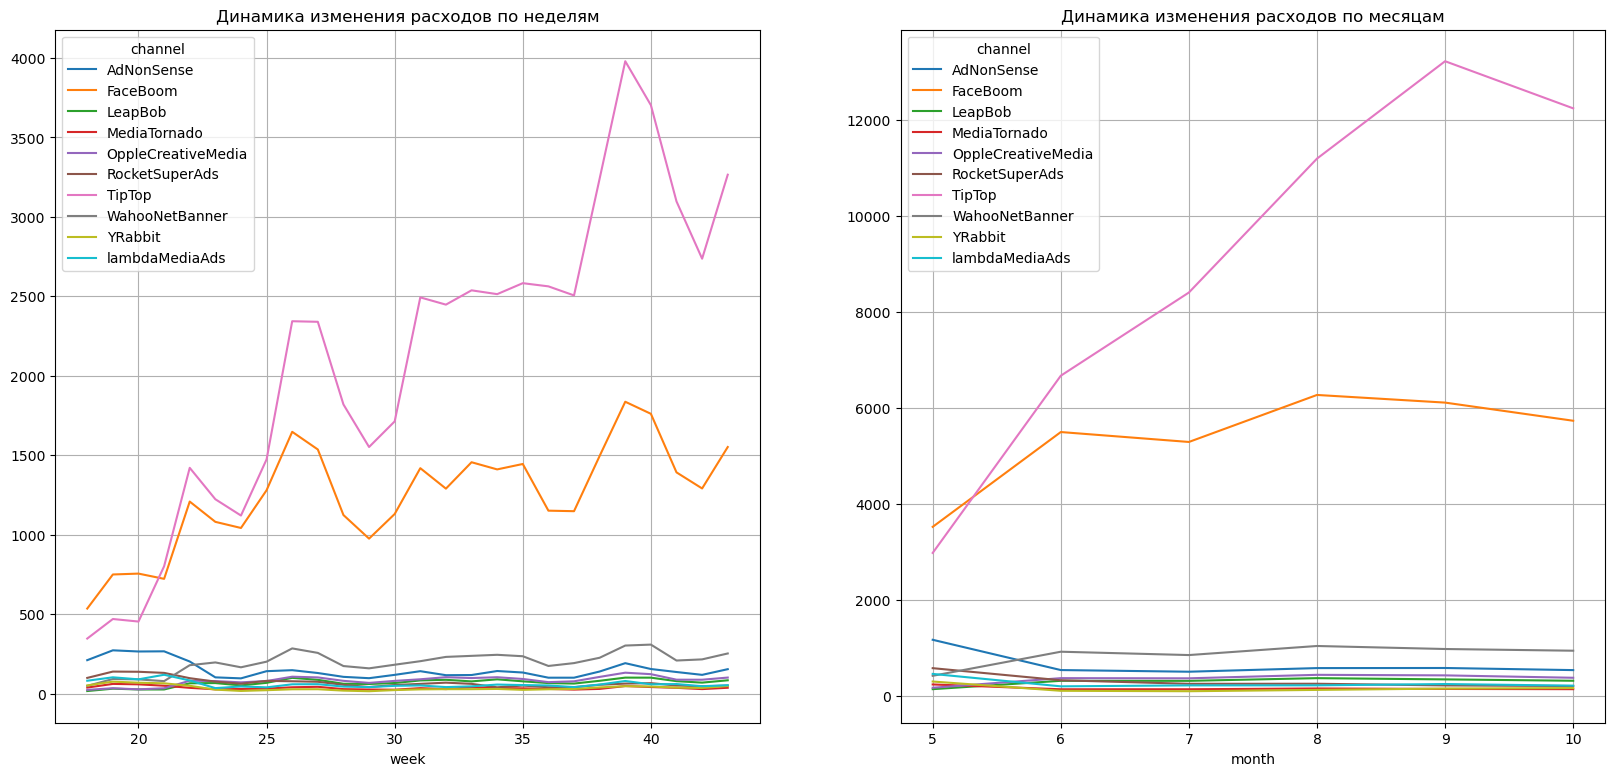

In [34]:
# добавим столбцы с номерами недель и месяцев
costs['dt'] = pd.to_datetime(costs['dt'])
costs['week'] = costs['dt'].dt.isocalendar().week
costs['month'] = costs['dt'].dt.month

plt.figure(figsize=(20, 9))

costs_week = costs.pivot_table(index='week', columns='channel', values='costs', aggfunc='sum')
costs_month = costs.pivot_table(index='month', columns='channel', values='costs', aggfunc='sum')

costs_week.plot(grid=True, ax=plt.subplot(1, 2, 1))
plt.title('Динамика изменения расходов по неделям')
costs_month.plot(grid=True, ax=plt.subplot(1, 2, 2))
plt.title('Динамика изменения расходов по месяцам')

plt.show()

**Вывод:**
Наблюдается сильный рост затрат на рекламу в канале `TipTop`.

На втором месте по затратам канал `FaceBoom`, ежемесячные затраты на него стабильны с июня и колеблются в районе 5000-6000, еженедельные в диапазоне 1000-1800.

В остальные каналы привлечения клиентов вкладывается намного меньше денег, затраты на них стабильно меньше 300 еженедельно и меньше 1000 ежемесячно.

### CAC

Узнаем, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника.

In [35]:
cac_channel = (
    profiles
    .groupby('channel')
    .agg({'acquisition_cost': 'mean'})
    .sort_values('acquisition_cost', ascending=False)
)
cac_channel

acquisition_cost
channel                             
TipTop                      2.799003
FaceBoom                    1.113286
AdNonSense                  1.008054
lambdaMediaAds              0.724802
WahooNetBanner              0.602245
RocketSuperAds              0.412095
OppleCreativeMedia          0.250000
YRabbit                     0.218975
MediaTornado                0.218717
LeapBob                     0.210172
organic                     0.000000

In [36]:
# посчитаем среднее значение CAC по всему проекту
cac_mean = profiles['acquisition_cost'].mean()

In [37]:
# выведем каналы с CAC выше среднего по проекту
cac_channel.query('acquisition_cost >= @cac_mean')

acquisition_cost
channel                         
TipTop                  2.799003
FaceBoom                1.113286
AdNonSense              1.008054
lambdaMediaAds          0.724802

**Вывод:**
Самый дорогие пользователи - привлечённые через канал `TipTop`. Не зря у этого канала самые высокие затраты на рекламу.

Также довольно выше среднего стоят пользователи из каналов `FaceBoom`, `AdNonSense` и `lambdaMediaAds`.

## Оценка окупаемости рекламы

### Окупаемость рекламы

Проанализируем окупаемость рекламы c помощью графиков LTV и ROI, а также графиков динамики LTV, CAC и ROI.

Установим момент анализа 1 ноября 2019 года. Горизонт анализа укажем 14 дней, так как пользователи должны окупаться не позднее чем через две недели после привлечения. Также исключим из анализа органических пользователей.

In [38]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа 1 ноября 2019 года
horizon_days = 14  # горизонт анализа 

In [39]:
#исключим органических пользователей
profiles = profiles.query('channel != "organic"')

Выделим отдельно пользователей из США и пользователей из Европы.

In [40]:
profiles_usa = profiles.query('region == "United States"')
profiles_usa.head()

user_id            first_ts       channel  device         region  \
0    599326 2019-05-07 20:58:57      FaceBoom     Mac  United States   
1   4919697 2019-07-09 12:46:07      FaceBoom  iPhone  United States   
4  31989216 2019-10-02 00:07:44       YRabbit  iPhone  United States   
8  58263264 2019-05-11 19:18:43      FaceBoom  iPhone  United States   
9  59835779 2019-05-11 21:13:47  MediaTornado  iPhone  United States   

           dt      month  payer  acquisition_cost  
0  2019-05-07 2019-05-01   True          1.088172  
1  2019-07-09 2019-07-01  False          1.107237  
4  2019-10-02 2019-10-01  False          0.230769  
8  2019-05-11 2019-05-01  False          1.128205  
9  2019-05-11 2019-05-01  False          0.250435

In [41]:
profiles_euro = profiles.query('region != "United States"')
profiles_euro.head()

user_id            first_ts         channel   device   region  \
3    22593348 2019-08-22 21:35:48      AdNonSense       PC  Germany   
7    46006712 2019-06-30 03:46:29      AdNonSense  Android   France   
17   93828625 2019-07-24 05:56:22         LeapBob   iPhone  Germany   
24  138399008 2019-07-20 16:59:16  WahooNetBanner       PC       UK   
42  267553828 2019-09-21 12:17:42  WahooNetBanner       PC   France   

            dt      month  payer  acquisition_cost  
3   2019-08-22 2019-08-01  False          0.988235  
7   2019-06-30 2019-06-01   True          1.008000  
17  2019-07-24 2019-07-01  False          0.204324  
24  2019-07-20 2019-07-01  False          0.635294  
42  2019-09-21 2019-09-01  False          0.591304

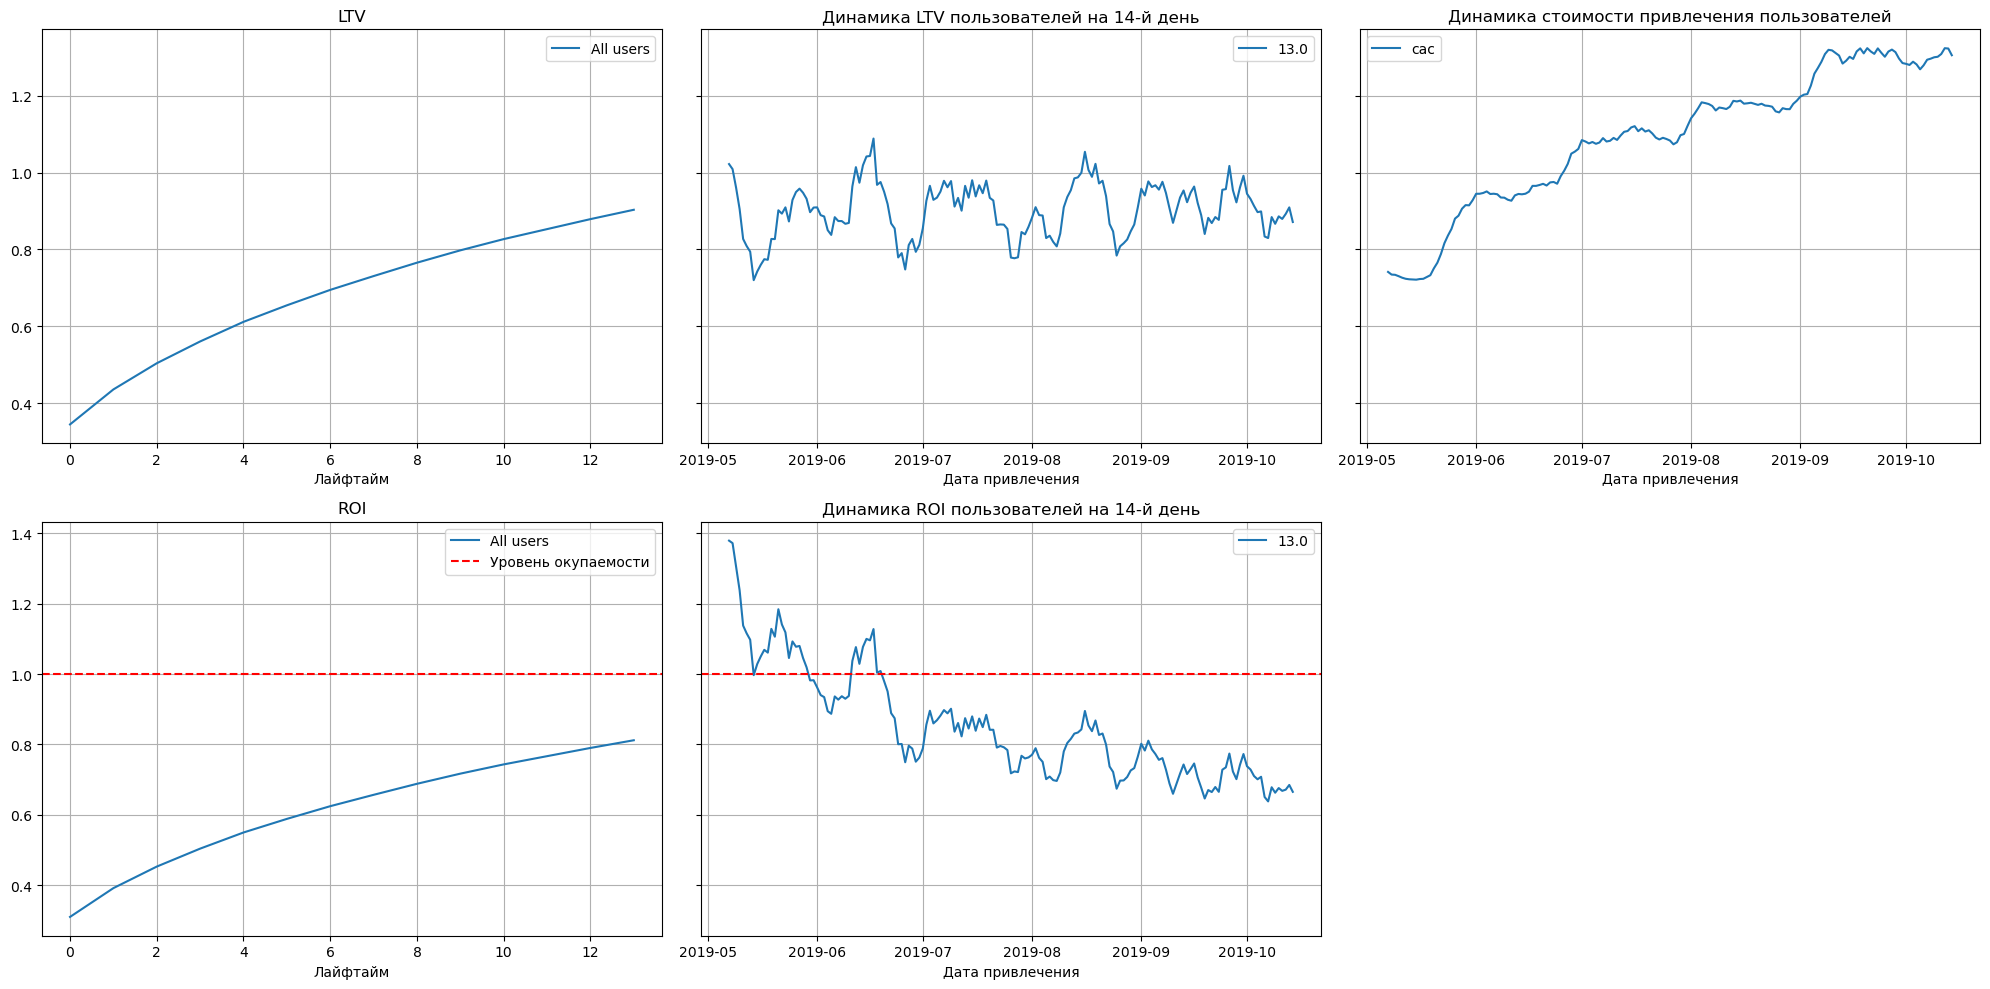

In [42]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, max_analysis_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

In [43]:
# проверка правильности расчётов ROI
max_acquisition_date = roi_history.reset_index()['dt'].max()
print(
   'Общие расходы на привлечение из таблицы ROI: {:.2f}'
    .format(roi_grouped.loc['All users', 'cac'] * roi_grouped.loc['All users', 'cohort_size'])
)
print(
   'Общие расходы на привлечение из таблицы costs: {:.2f}'
    .format(costs.query('dt <= @max_acquisition_date')['costs'].sum())
) 

Общие расходы на привлечение из таблицы ROI: 95805.73
Общие расходы на привлечение из таблицы costs: 95805.74


**Вывод:**
- Затраты на рекламу не окупаются - к концу второй недели кривая ROI не доходит до единицы.
- Показатель LTV достаточно стабилен - на 14-й день жизни пользователи приносят порядка 0.8-1 в день.
- Показатель CAC растёт - пользователи становятся всё более и более дорогими, в конце периода CAC примерно равен 1.25.
- С резким ростом стоимости привлечения клиентов падает окупаемость инвестиций. В июне клиенты перестали окупаться совсем.

### Удержание

Проверим удержание пользователей.

In [44]:
# максимально возможная дата привлечения клиентов
last_suitable_acquisition_date = observation_date - timedelta(days=horizon_days - 1)
last_suitable_acquisition_date

datetime.date(2019, 10, 19)

In [45]:
# считаем удержание
retention_raw, retention, retention_history = get_retention(profiles, visits, observation_date, horizon_days)
# таблица удержания
retention

cohort_size    0         1         2         3         4         5  \
payer                                                                       
False        81334  1.0  0.176876  0.086594  0.051823  0.033504  0.024701   
True          7310  1.0  0.380985  0.293023  0.235568  0.210260  0.191245   

              6         7         8         9        10        11        12  \
payer                                                                         
False  0.018651  0.014188  0.011729  0.009541  0.007488  0.006393  0.006012   
True   0.166758  0.156908  0.145144  0.136389  0.135021  0.121888  0.118741   

             13  
payer            
False  0.004709  
True   0.104925

In [46]:
# таблица динамики удержания
retention_history.tail() 

cohort_size    0         1         2         3         4  \
payer dt                                                                     
True  2019-10-15           38  1.0  0.421053  0.263158  0.236842  0.157895   
      2019-10-16           27  1.0  0.481481  0.407407  0.259259  0.074074   
      2019-10-17           36  1.0  0.305556  0.250000  0.194444  0.083333   
      2019-10-18           56  1.0  0.321429  0.321429  0.232143  0.214286   
      2019-10-19           51  1.0  0.372549  0.333333  0.176471  0.176471   

                         5         6         7         8         9        10  \
payer dt                                                                       
True  2019-10-15  0.105263  0.078947  0.157895  0.131579  0.157895  0.105263   
      2019-10-16  0.148148  0.222222  0.148148  0.111111  0.111111  0.185185   
      2019-10-17  0.111111  0.027778  0.111111  0.166667  0.138889  0.111111   
      2019-10-18  0.321429  0.125000  0.142857  0.196429  0.142857  0.142857   
      2019-10-19  0.176471  0.117647  0.176471  0.156863  0.137255  0.117647   

                        11        12        13  
payer dt                                        
True  2019-10-15  0.105263  0.026316  0.157895  
      2019-10-16  0.037037  0.037037  0.111111  
      2019-10-17  0.027778  0.138889  0.000000  
      2019-10-18  0.142857  0.089286  0.035714  
      2019-10-19  0.117647  0.117647  0.000000

После учёта горизонта и момента анализа данных таблица удержания включает только данные пользователей, привлечённых по 19 октября 2019 года включительно.

Чтобы удостовериться, что сумма размеров когорт равна числу новых клиентов в изучаемый период, посчитаем количество уникальных пользователей за изучаемый период по столбцу `user_id` в профилях и сравним его с суммой значений в столбце `cohort_size` из таблицы удержания.

Чтобы проверить, что сумма размеров платящих когорт равна числу покупателей в изучаемый период, возьмём только платящих пользователей.

In [47]:
# в профилях находим пользователей, привлечённых по 19 октября 2019 года включительно
report = profiles.query('dt <= @last_suitable_acquisition_date')
# считаем уникальных пользователей в профилях и складываем размеры когорт
print(
    'Общее количество новых пользователей: {} {}'.format(
        len(report['user_id'].unique()), retention['cohort_size'].sum()
    )
)

Общее количество новых пользователей: 88644 88644


In [48]:
# в профилях находим платящих пользователей, привлечённых по 19 октября 2019 года включительно
report = profiles.query('dt <= @last_suitable_acquisition_date and payer == True')
# считаем уникальных платящих пользователей в профилях и складываем размеры платящих когорт
print(
    'Общее количество новых покупателей: {} {}'.format(
        len(report['user_id'].unique()),
        retention.query('payer == True')['cohort_size'].sum()
    )  
)

Общее количество новых покупателей: 7310 7310


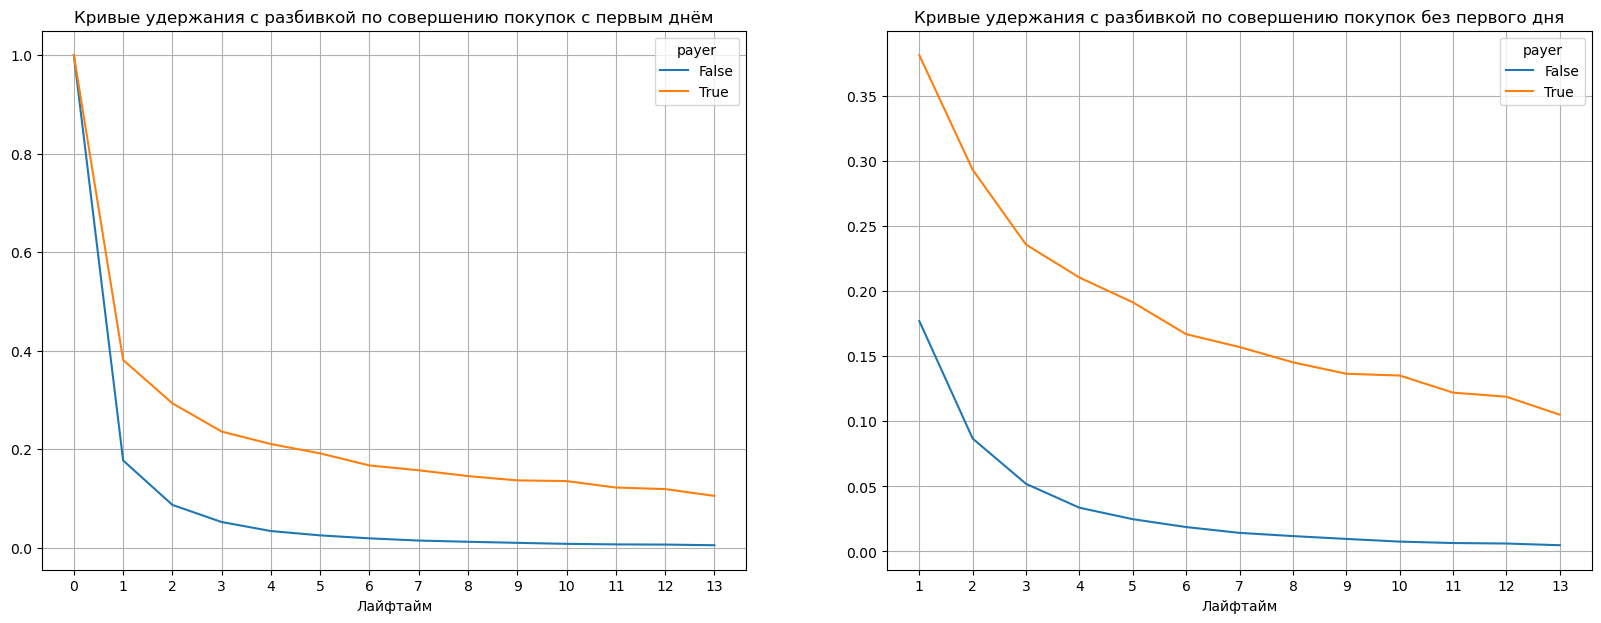

In [49]:
# построим кривые удержания
plt.figure(figsize=(20, 7))
report = retention.drop(columns=['cohort_size'])
report.T.plot(grid=True, xticks=list(report.columns.values), ax=plt.subplot(1, 2, 1))
plt.xlabel('Лайфтайм')
plt.title('Кривые удержания с разбивкой по совершению покупок с первым днём')

report = retention.drop(columns=['cohort_size', 0])
report.T.plot(grid=True, xticks=list(report.columns.values), ax=plt.subplot(1, 2, 2))
plt.xlabel('Лайфтайм')
plt.title('Кривые удержания с разбивкой по совершению покупок без первого дня')
plt.show()

**Вывод:**
- Сумма размеров когорт равна количеству новых пользователей (для всех клиентов и для платящих).
- Удержание первого дня равно единице для платящих и неплатящих пользователей.
- Кривая платящих выше кривой удержания неплатящих.
- Удержание убывает.

**Проверка удержания пройдена успешно.**

### Конверсия

Сделаем проверку расчётов конверсии.

In [50]:
# считаем конверсию
conversion_raw, conversion, conversion_history = get_conversion(profiles, orders, observation_date, horizon_days)
# таблица конверсии
conversion

cohort_size       0.0       1.0       2.0       3.0     4.0  \
cohort                                                                   
All users        88644  0.058752  0.066321  0.069999  0.072571  0.0745   

                5.0       6.0       7.0       8.0       9.0      10.0  \
cohort                                                                  
All users  0.075775  0.076745  0.077591  0.078291  0.078945  0.079362   

               11.0      12.0      13.0  
cohort                                   
All users  0.079678  0.079904  0.080197

In [51]:
# таблица динамики конверсии
conversion_history.head()

cohort_size       0.0       1.0       2.0       3.0       4.0  \
dt                                                                          
2019-05-01          390  0.058974  0.066667  0.071795  0.071795  0.076923   
2019-05-02          323  0.058824  0.068111  0.068111  0.068111  0.068111   
2019-05-03          346  0.057803  0.069364  0.075145  0.078035  0.083815   
2019-05-04          457  0.070022  0.074398  0.076586  0.078775  0.085339   
2019-05-05          438  0.036530  0.043379  0.047945  0.052511  0.052511   

                 5.0       6.0       7.0       8.0       9.0      10.0  \
dt                                                                       
2019-05-01  0.076923  0.076923  0.079487  0.082051  0.082051  0.082051   
2019-05-02  0.068111  0.068111  0.068111  0.068111  0.068111  0.071207   
2019-05-03  0.083815  0.083815  0.083815  0.083815  0.083815  0.083815   
2019-05-04  0.085339  0.087527  0.089716  0.089716  0.091904  0.091904   
2019-05-05  0.052511  0.052511  0.052511  0.052511  0.052511  0.052511   

                11.0      12.0      13.0  
dt                                        
2019-05-01  0.082051  0.082051  0.082051  
2019-05-02  0.071207  0.071207  0.071207  
2019-05-03  0.083815  0.083815  0.086705  
2019-05-04  0.091904  0.091904  0.091904  
2019-05-05  0.052511  0.052511  0.052511

Сверим количество уникальных пользователей за изучаемый период по столбцу `user_id` в профилях и сумму значений `cohort_size` из таблицы конверсии.

In [52]:
# в профилях находим пользователей, привлечённых по 19 октября 2019 года включительно
report = profiles.query('dt <= @last_suitable_acquisition_date')
# считаем уникальных пользователей в профилях и складываем размеры когорт
print(
    'Общее количество новых пользователей: {} {}'
    .format(len(report['user_id'].unique()), conversion['cohort_size'].sum())
)

Общее количество новых пользователей: 88644 88644


Оценим кривую конверсии. Кривая должна начинаться на уровне конверсии первого дня и затем бесконечно приближаться к единице.

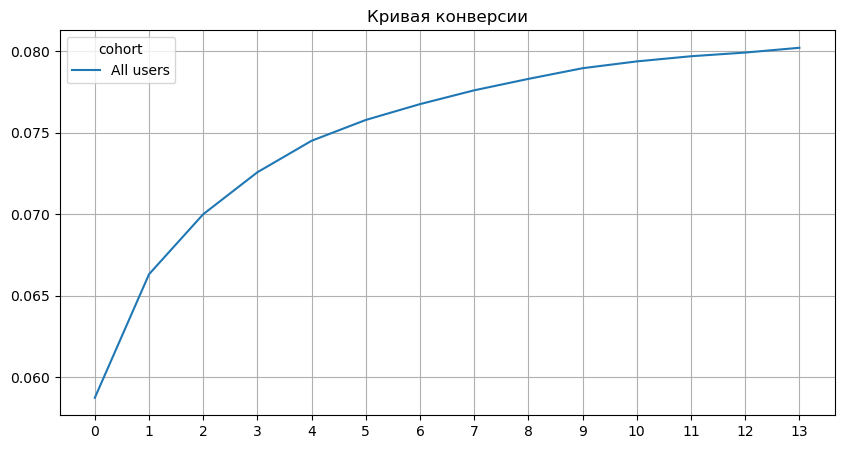

In [53]:
# построим кривую конверсии
report = conversion.drop(columns=['cohort_size'])
report.T.plot(grid=True, xticks=list(report.columns.values), figsize=(10, 5))
plt.title('Кривая конверсии')
plt.show()

Убедимся, что в таблицах конверсий нет значений больше единицы. Сделаем срез таблицы конверсии по условию > 1 и заменим остальные значения на пустую строку методом fillna(). Так в таблице останутся только значения больше единицы.

In [54]:
conversion[conversion > 1].fillna('')

cohort_size 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0  \
cohort                                                                          
All users        88644                                                          

          13.0  
cohort          
All users

In [55]:
# выведем все строки получившейся таблицы
pd.set_option('display.max_rows', None)
conversion_history[conversion_history > 1].fillna('')

cohort_size 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0  \
dt                                                                          
2019-05-01          390                                                     
2019-05-02          323                                                     
2019-05-03          346                                                     
2019-05-04          457                                                     
2019-05-05          438                                                     
2019-05-06          443                                                     
2019-05-07          382                                                     
2019-05-08          354                                                     
2019-05-09          343                                                     
2019-05-10          421                                                     
2019-05-11          472                                                     
2019-05-12          393                                                     
2019-05-13          412                                                     
2019-05-14          356                                                     
2019-05-15          316                                                     
2019-05-16          376                                                     
2019-05-17          360                                                     
2019-05-18          439                                                     
2019-05-19          436                                                     
2019-05-20          372                                                     
2019-05-21          355                                                     
2019-05-22          365                                                     
2019-05-23          359                                                     
2019-05-24          332                                                     
2019-05-25          399                                                     
2019-05-26          425                                                     
2019-05-27          387                                                     
2019-05-28          399                                                     
2019-05-29          505                                                     
2019-05-30          462                                                     
2019-05-31          599                                                     
2019-06-01          627                                                     
2019-06-02          638                                                     
2019-06-03          470                                                     
2019-06-04          411                                                     
2019-06-05          431                                                     
2019-06-06          410                                                     
2019-06-07          492                                                     
2019-06-08          437                                                     
2019-06-09          469                                                     
2019-06-10          412                                                     
2019-06-11          351                                                     
2019-06-12          321                                                     
2019-06-13          319                                                     
2019-06-14          418                                                     
2019-06-15          486                                                     
2019-06-16          546                                                     
2019-06-17          422                                                     
2019-06-18          398                                                     
2019-06-19          390                                                     
2019-06-

Проверим, равно ли число новых покупателей из таблицы с данными о покупках `orders` размеру когорты, умноженному на конверсию за последний лайфтайм.

In [56]:
# рассчитываем число покупателей по данным из таблицы конверсии
print(
    'Количество уникальных покупателей из таблицы конверсии: {:.0f}'
    .format(conversion['cohort_size'][0] * conversion[13][0])
)

Количество уникальных покупателей из таблицы конверсии: 7109


In [57]:
# рассчитываем число покупателей по данным о покупках
# берём данные пользователей, привлечённых по 19 октября 2019 года включительно
report = orders.merge(
    profiles.query('dt <= @last_suitable_acquisition_date'), on='user_id'
)
# рассчитываем лайфтайм для каждой покупки
report['lifetime'] = (report['event_dt'] - report['first_ts']).dt.days
# исключаем лишние лайфтаймы
report = report.query('lifetime <= 13')

print(
    'Количество уникальных покупателей из таблицы заказов: {:.0f}'
    .format(len(report['user_id'].unique()))
) 

Количество уникальных покупателей из таблицы заказов: 7109


**Вывод:**
- Количества новых пользователей, рассчитанные по таблице профилей и по таблице конверсии, равны.
- В таблицах конверсии и динамики конверсии отсутствуют значения больше единицы.
- Кривая конверсии начинается на уровне конверсии первого дня и затем бесконечно приближается к единице.
- Число новых покупателей из таблицы с покупками равно размеру когорты, умноженному на конверсию за последний лайфтайм.

**Проверка конверсии пройдена успешно.**

### Окупаемость рекламы с разбивкой по устройствам

Проанализируем окупаемость рекламы с разбивкой по устройствам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

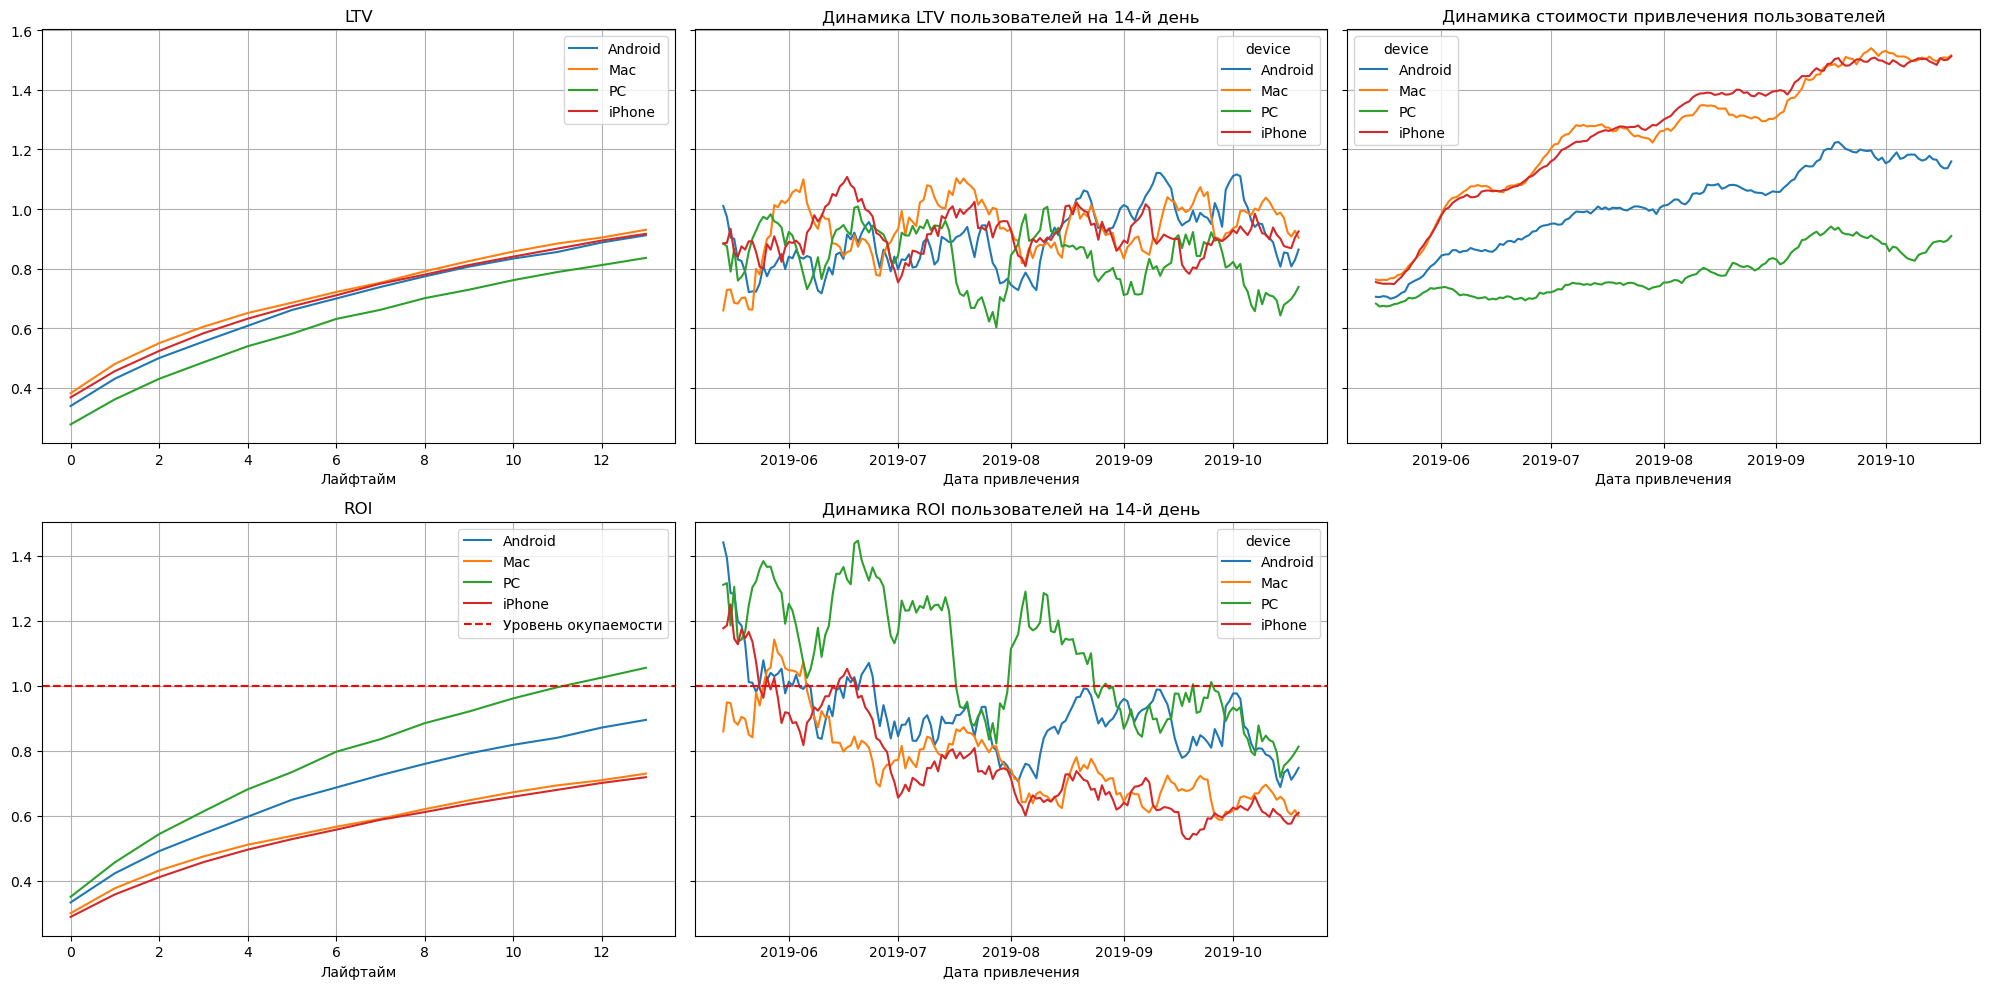

In [58]:
# окупаемость с разбивкой по устройствам
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14)

- LTV пользователей разных устройств идут примерно на одном уровне, немного отстают пользователи `PC`.
- LTV в динамике стабильно находится на уровне 0.8-1.0.
- Стоимость привлечения растёт для пользователей всех устройств. Пользователи `Mac` и `iPhone` - самые дорогие.
- Из всех устройств окупаются только пользователи `PC` - за 11 дней.
- В динамике ROI пользователей всех устройств падает.

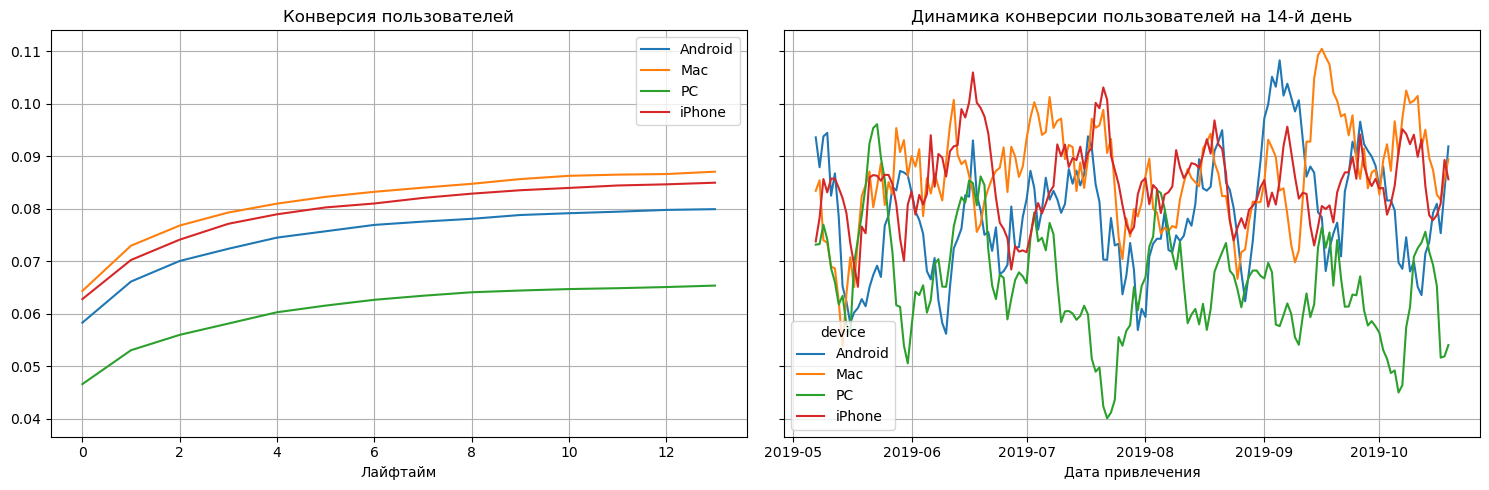

In [59]:
# конверсия с разбивкой по устройствам
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

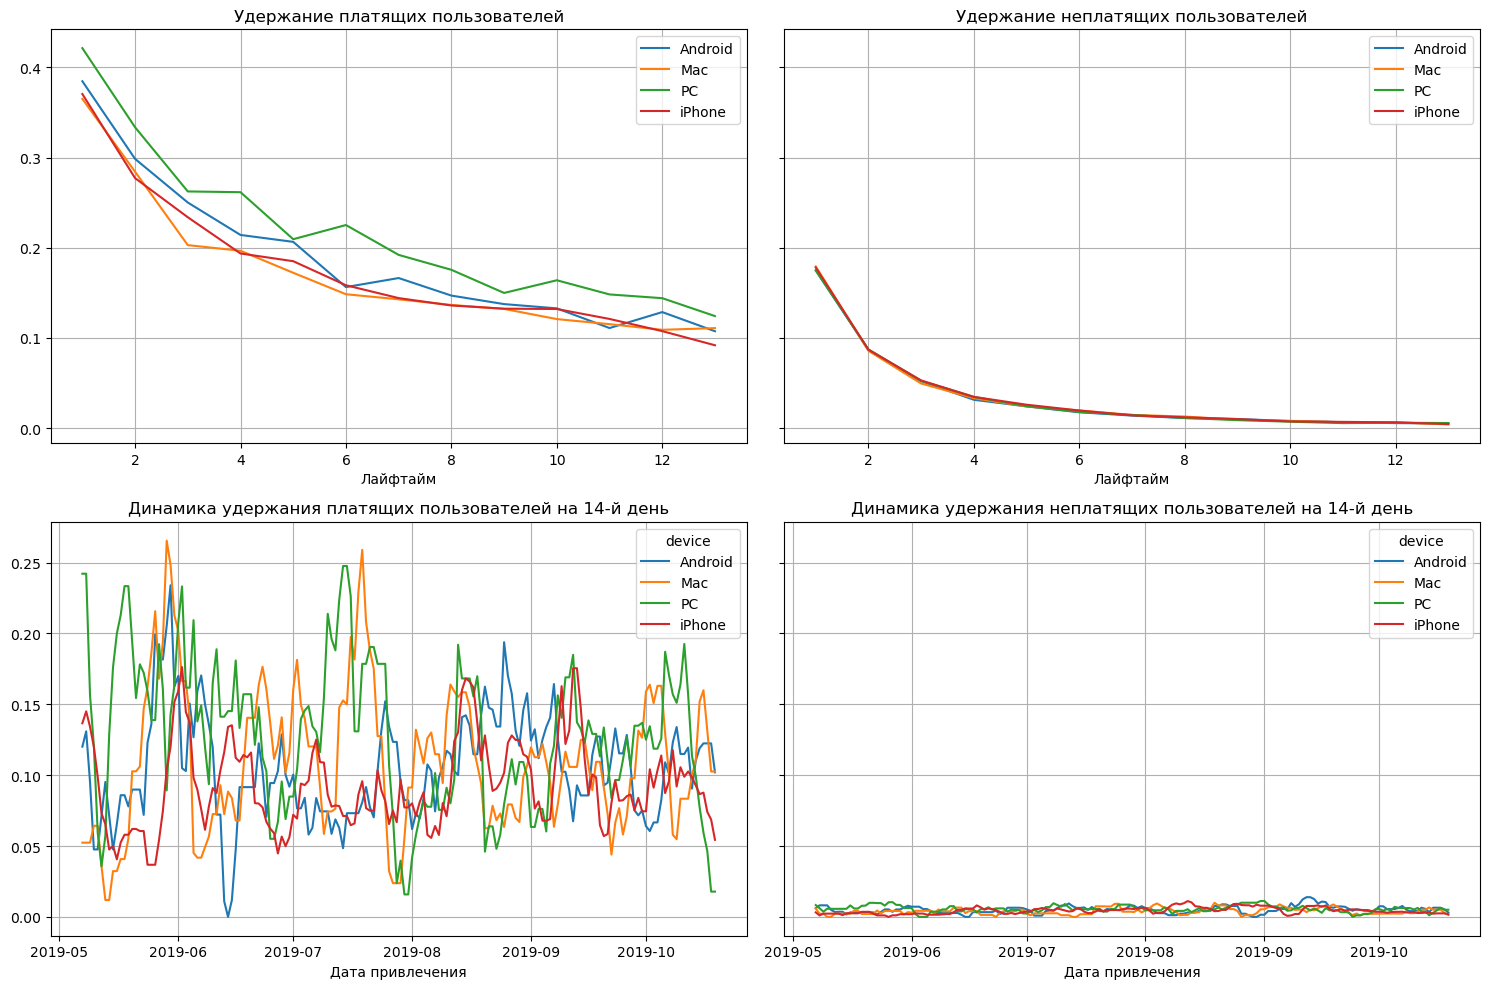

In [60]:
# удержание с разбивкой по устройствам
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

У пользователей PC конверсия ниже остальных. Удержание этих пользователей чуть выше остальных.

**Вывод:**

Из всех клиентов окупаются только пользователи `PC`, но у них низкая конверсия.

### Окупаемость рекламы с разбивкой по странам

Проанализируем окупаемость рекламы с разбивкой по странам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

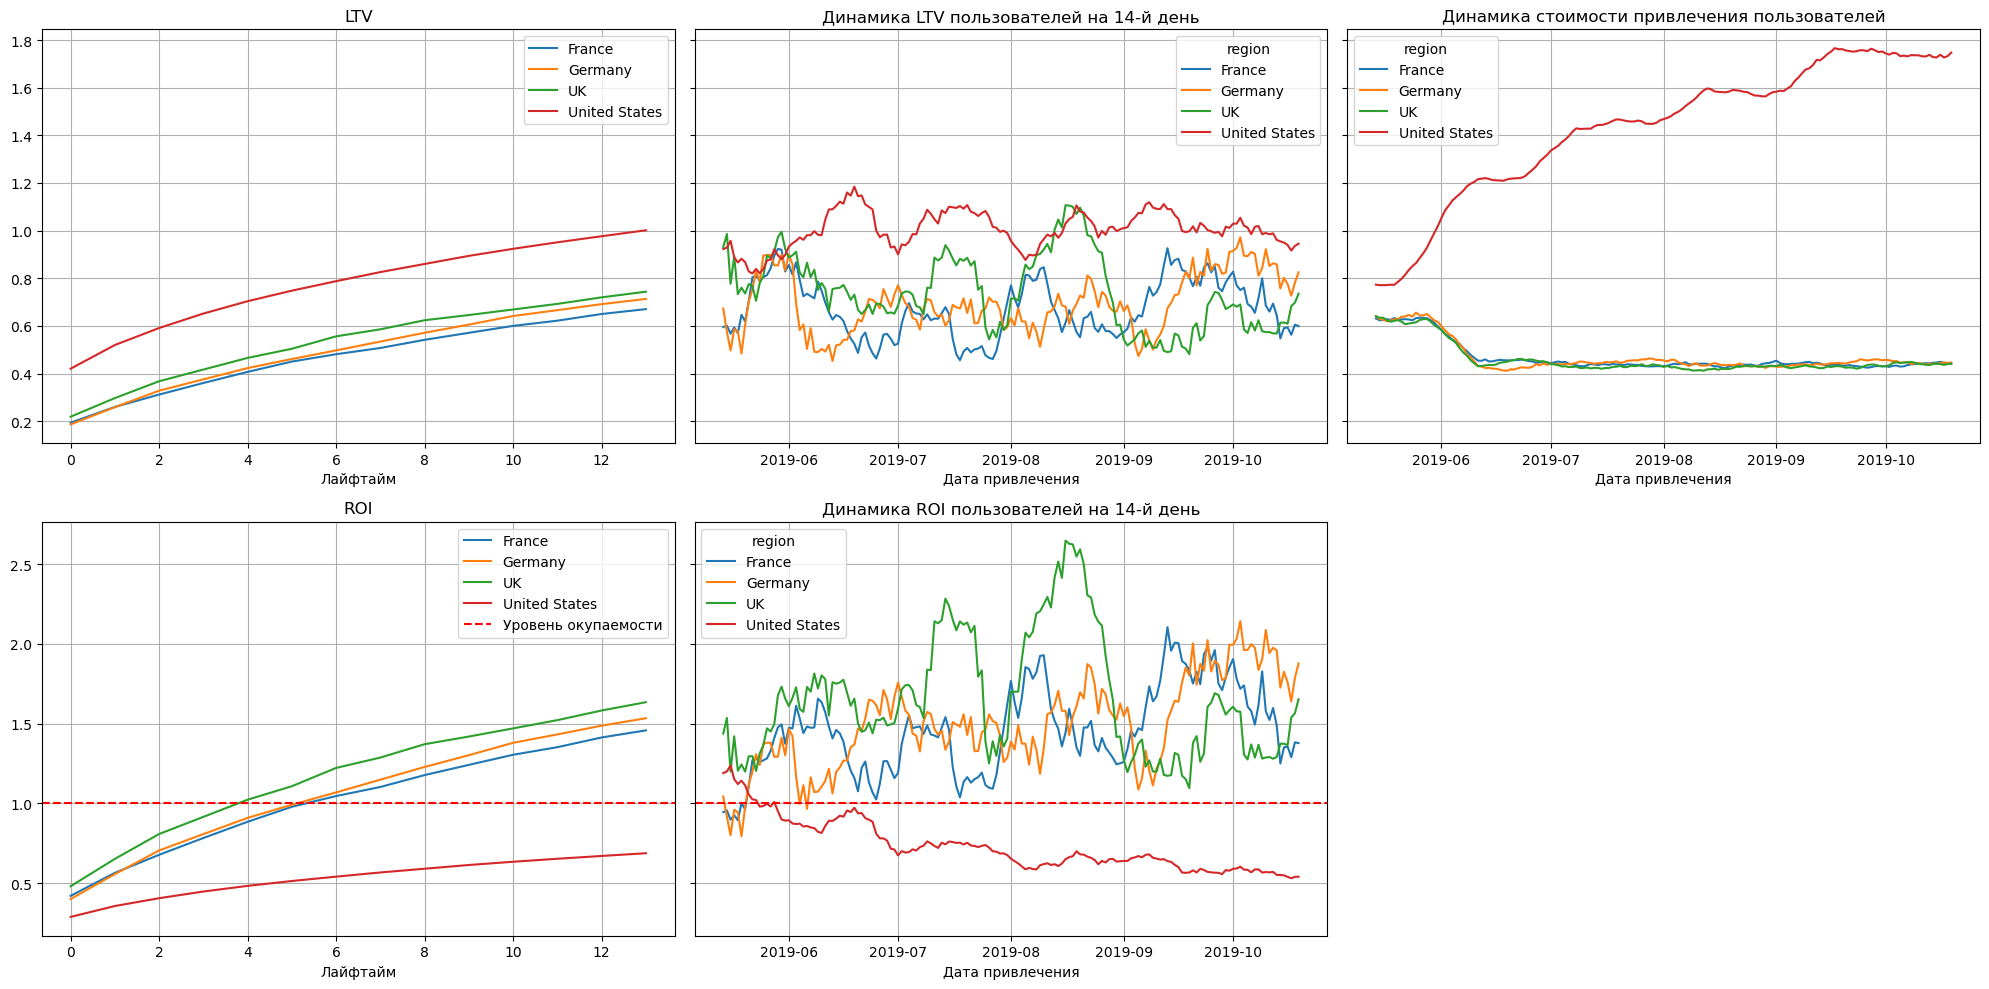

In [61]:
# окупаемость с разбивкой по странам
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14)

- Больше всего трат в приложении у пользователей из США.
- LTV в динамике у всех стран в диапазоне 0.5-1.1, лидирует США.
- В то же время в США самые дорогие пользователи, стоимость их привлечения неуклонно растёт. Интересно, что показатели CAC пользователей других стран снизились в июне и на момент анализа стабильно находятся на уровне 0.45.
- Пользователи из США совсем не окупаются. В среднем пользователи других стран окупаются за 4-6 дней. По скорости окупаемости лидирует Великобритания.
- Пользователи из США окупались в начале исследуемого периода, когда стоимость их привлечения была не так высока.

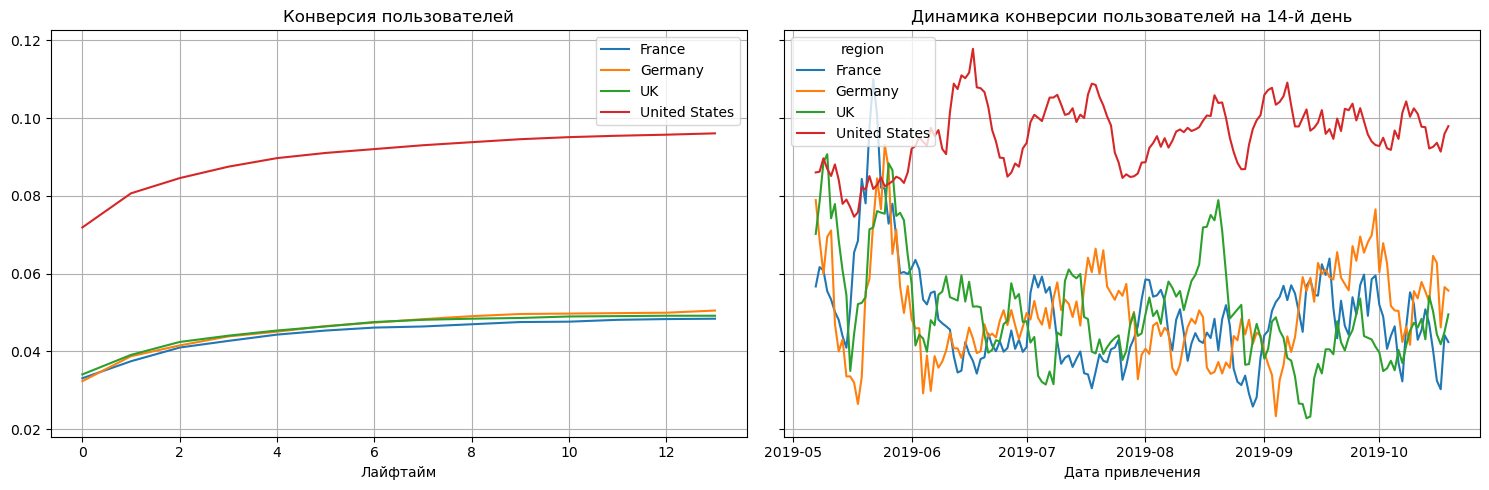

In [62]:
# конверсия с разбивкой по странам
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

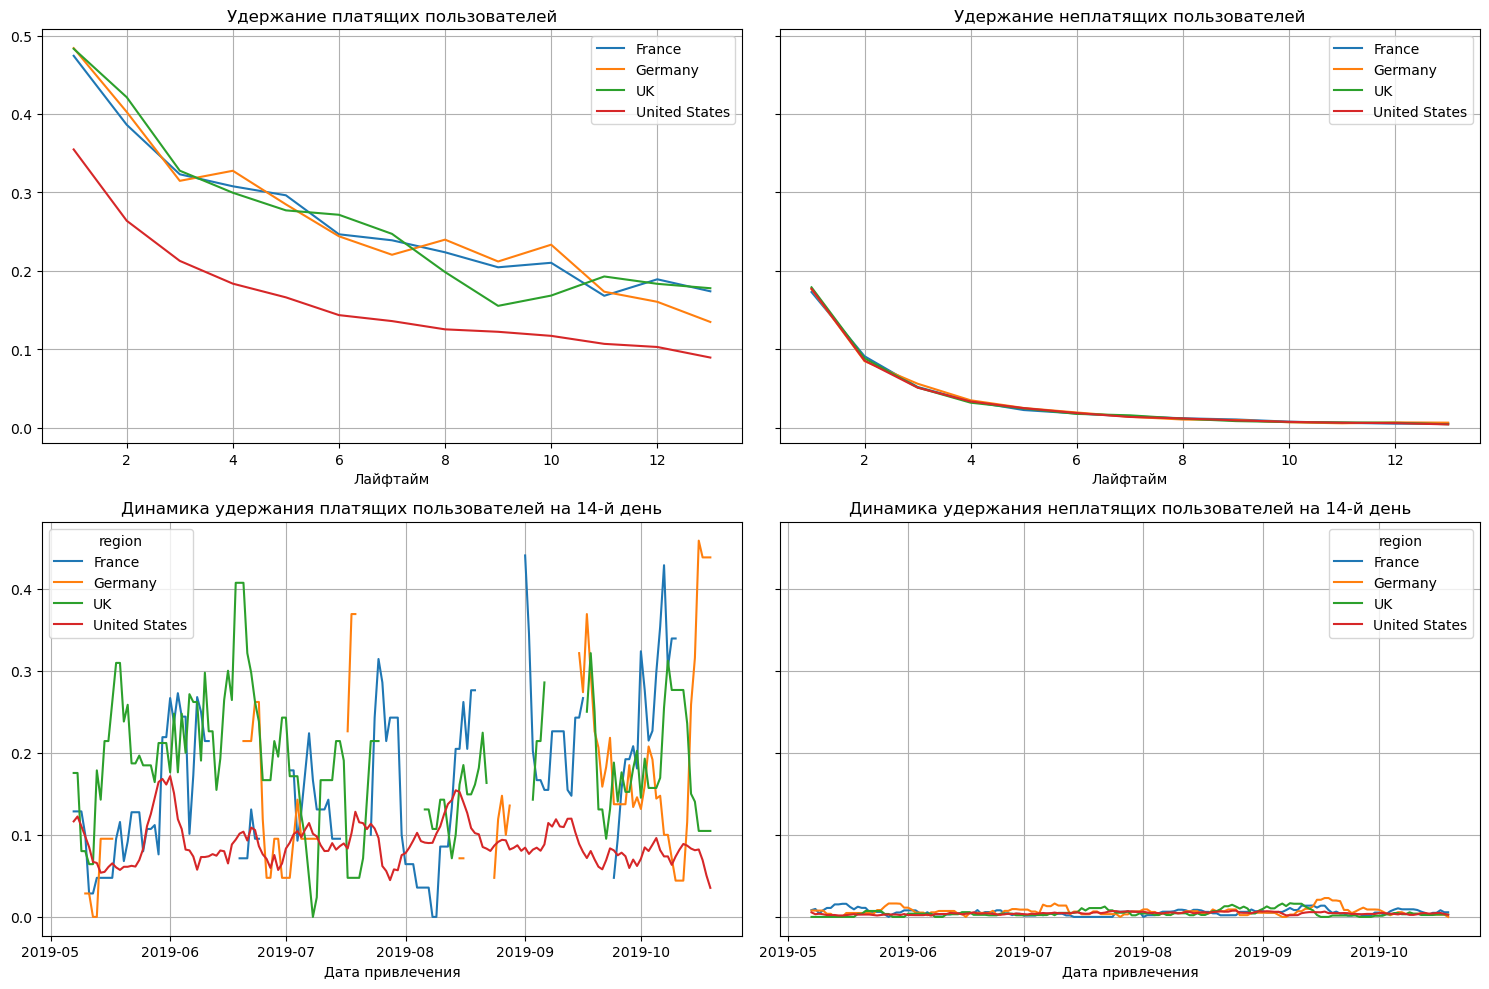

In [63]:
# удержание с разбивкой по странам
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

**Вывод:**
- У США высокая конверсия пользователей, но очень высокая стоимость привлечения. 
- Также у пользователей из США низкое удержание - возможно, имеется какая-то техническая проблема или это связано с особенностями культуры.
- Пользователи из Европы имеют стабильные окупаемость, удержание и конверсию - стоит направить силы на эти регионы.

### Окупаемость рекламы с разбивкой по рекламным каналам

Проанализируем окупаемость рекламы с разбивкой по рекламным каналам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

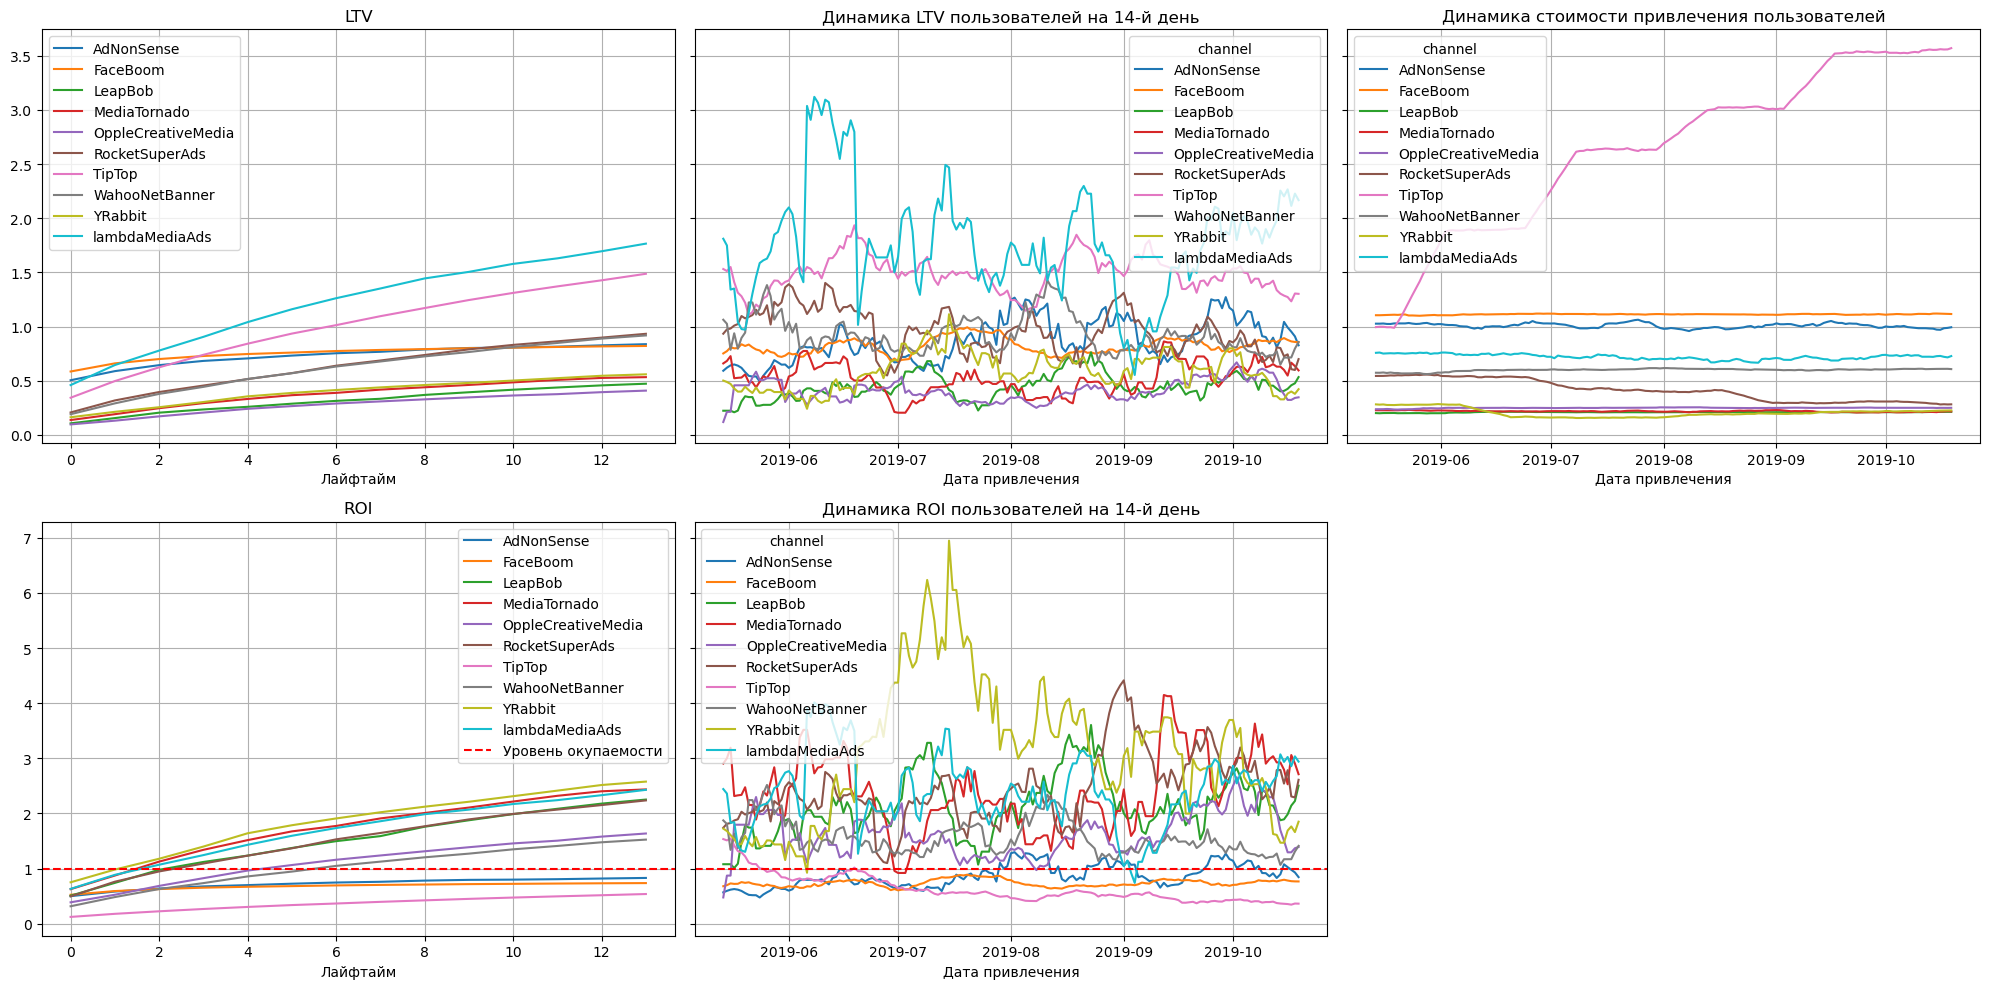

In [64]:
# окупаемость с разбивкой по рекламным каналам
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14)

- Пользователи, привлечённые из каналов lambdaMediaAds и TipTop совершают больше покупок, чем остальные.
- Стоимость привлечения из канала TipTop ступеньчато растёт. Пользователи из других каналов имеют стабильный CAC.
- Пользователи из каналов AdNonSense, FaceBoom и TipTop не окупаются. Другие пользователи окупаются довольно быстро - за 1-5 дней.В лидерах YRabbit, MediaTornado и lambdaMediaAds.
- Канал YRabbit приносил особенно много прибыли в июле.

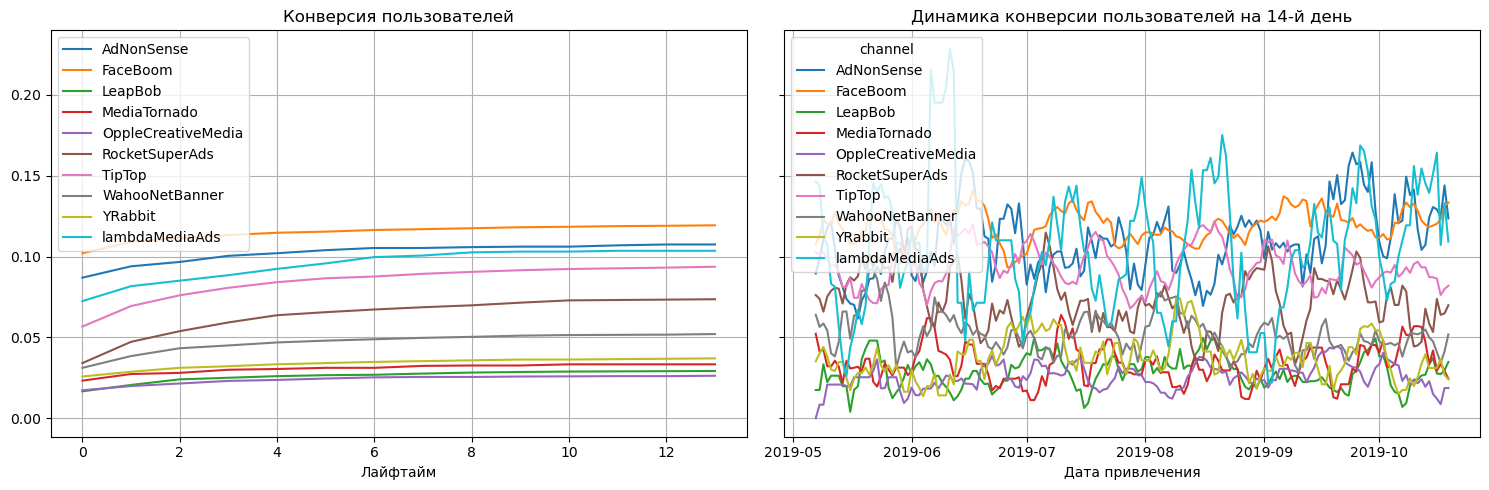

In [65]:
# конверсия с разбивкой по рекламным каналам
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

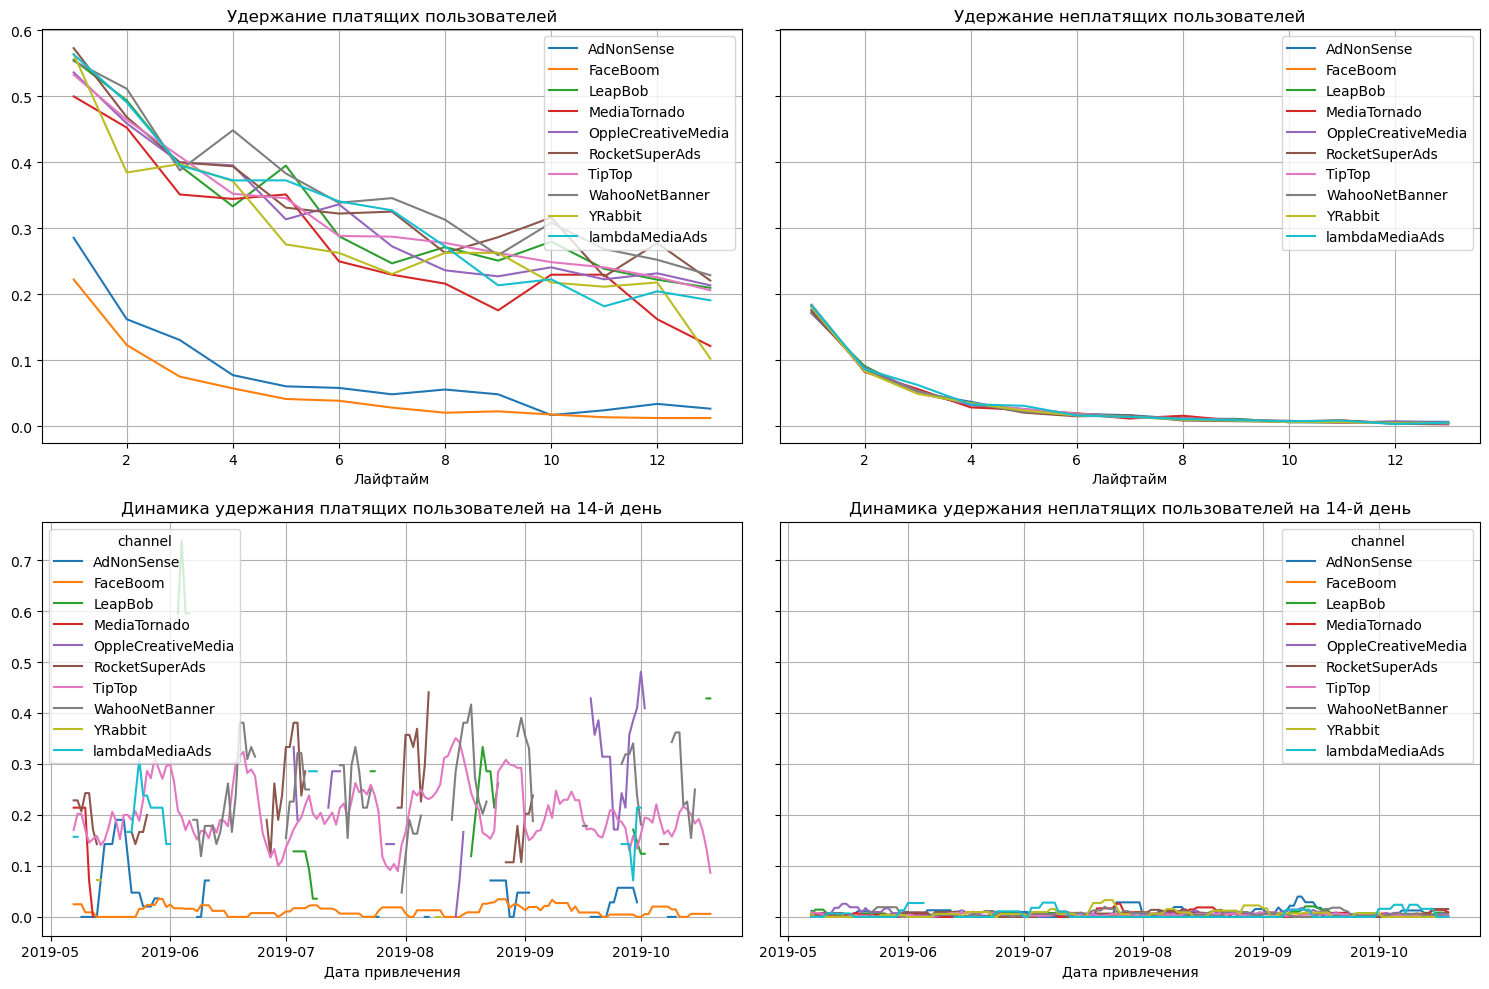

In [66]:
# удержание с разбивкой по рекламным каналам
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

**Вывод:**
- Пользователи из канала TipTop очень дорогие и совсем не окупаются.
- Пользователи из каналов AdNonSense и FaceBoom не окупаются. Также у этих каналов высокая конверсия, но низкое удержание. Возможно, это не целевая аудитория приложения, клиенты быстро уходят.
- В лидерах по окупаемости YRabbit, MediaTornado и lambdaMediaAds. Пользователи из lambdaMediaAds также имеют высокий LTV, высокую конверсию и хорошее удержание - стоит обратить внимание на этот канал.

### Окупаемость рекламы в США

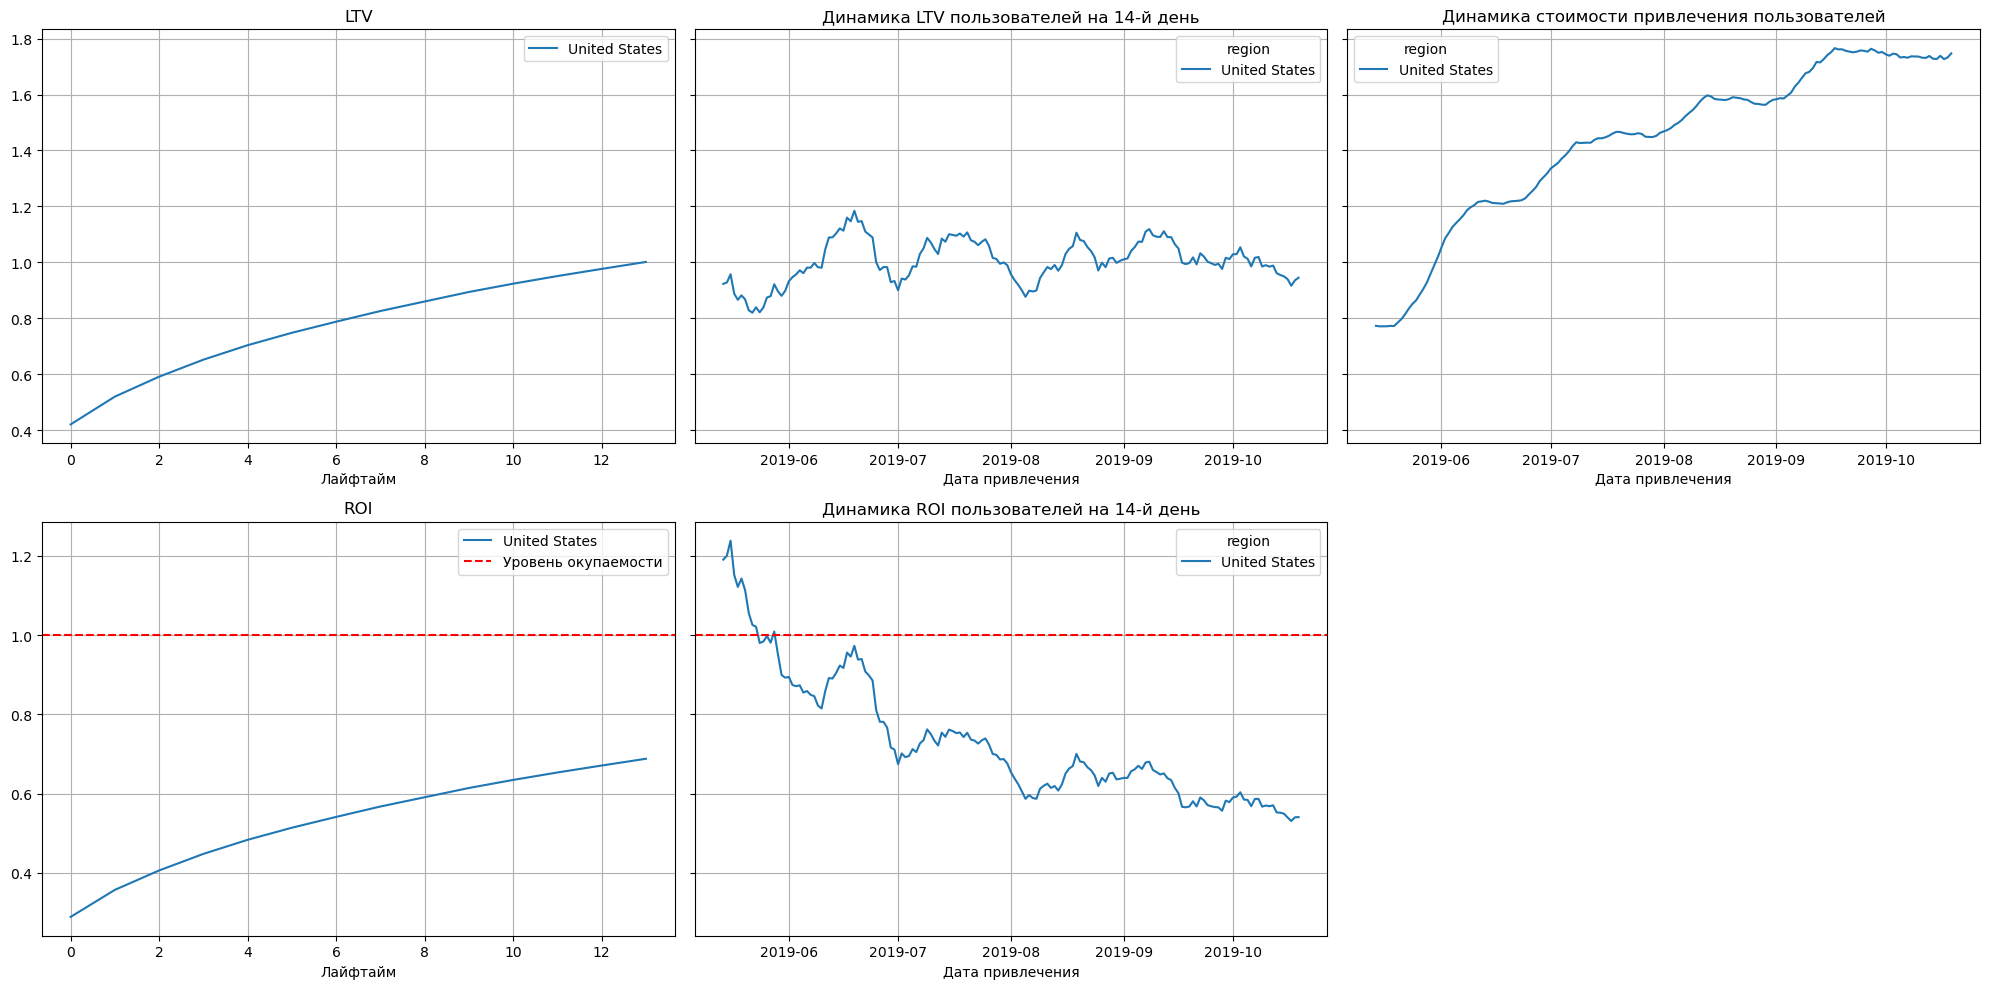

In [67]:
# окупаемость рекламы в США
dimensions = ['region']

ltv_raw_usa, ltv_grouped_usa, ltv_history_usa, roi_grouped_usa, roi_history_usa = get_ltv(
    profiles_usa, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(ltv_grouped_usa, ltv_history_usa, roi_grouped_usa, roi_history_usa, horizon_days, window=14)

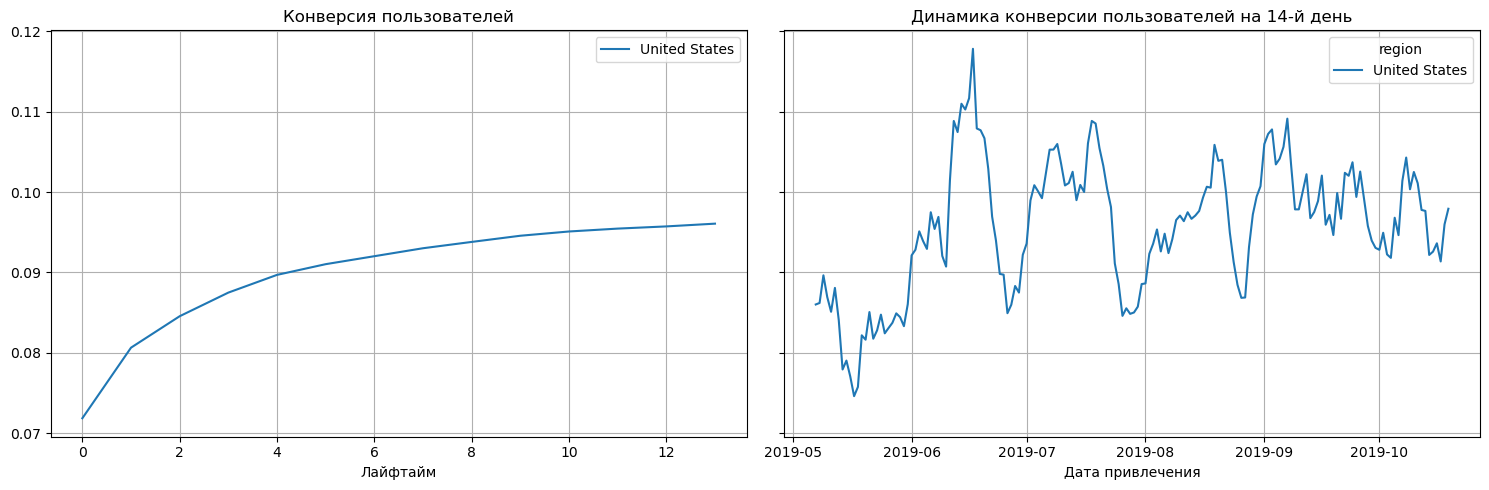

In [68]:
# конверсия в США
conversion_raw_usa, conversion_grouped_usa, conversion_history_usa = get_conversion(
    profiles_usa, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped_usa, conversion_history_usa, horizon_days) 

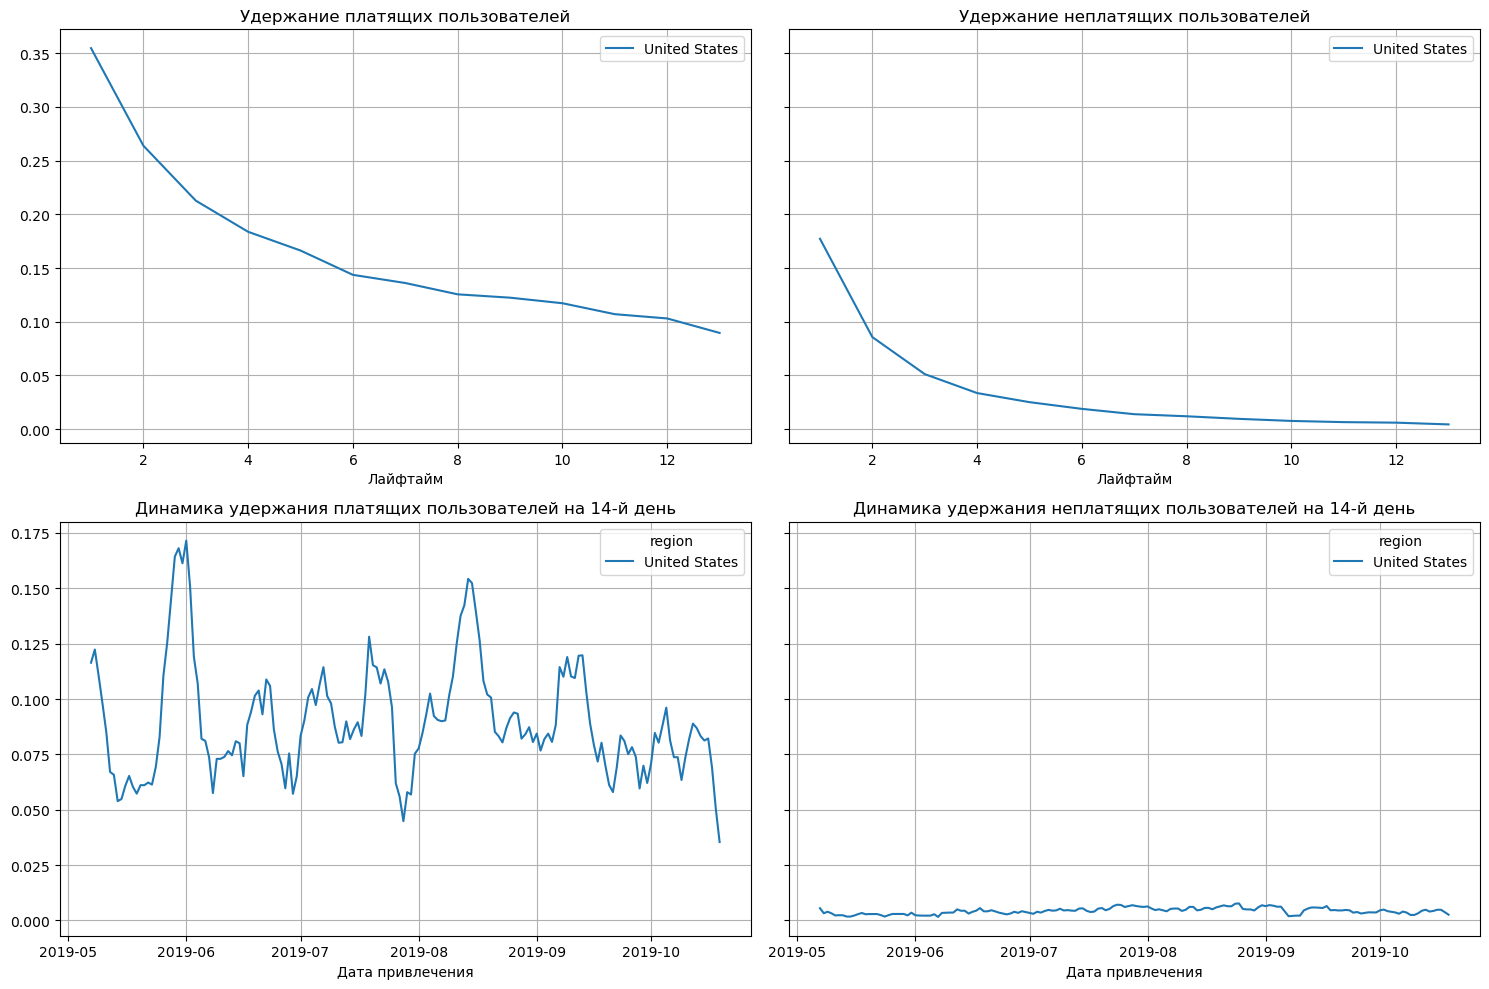

In [69]:
# удержание в США
retention_raw_usa, retention_grouped_usa, retention_history_usa = get_retention(
    profiles_usa, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped_usa, retention_history_usa, horizon_days) 

**Вывод:**
- Реклама в США не окупается.
- Стоимость привлечения постоянно растёт.
- Высокая конверсия у `FaceBoom` и `TipTop`.

#### С разбивкой по устройствам

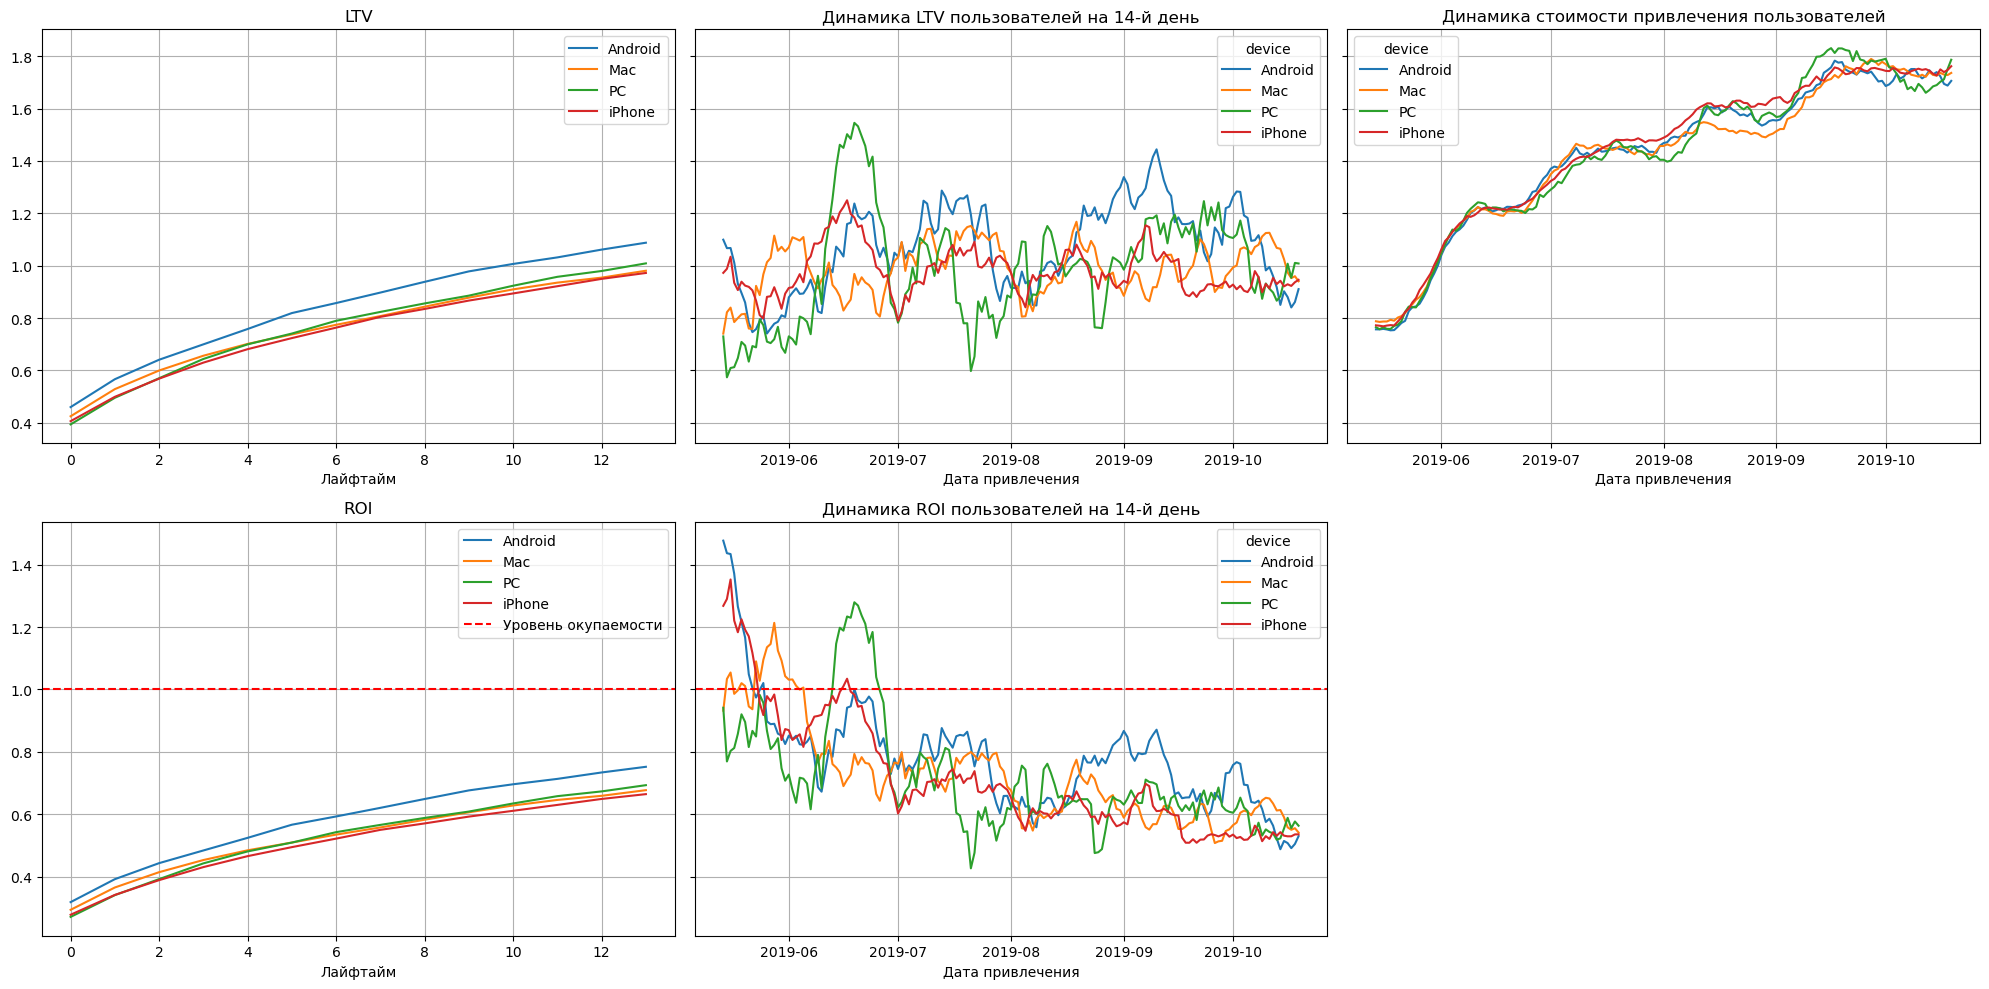

In [70]:
# окупаемость в США с разбивкой по устройствам
dimensions = ['device']

ltv_raw_usa, ltv_grouped_usa, ltv_history_usa, roi_grouped_usa, roi_history_usa = get_ltv(
    profiles_usa, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(ltv_grouped_usa, ltv_history_usa, roi_grouped_usa, roi_history_usa, horizon_days, window=14)

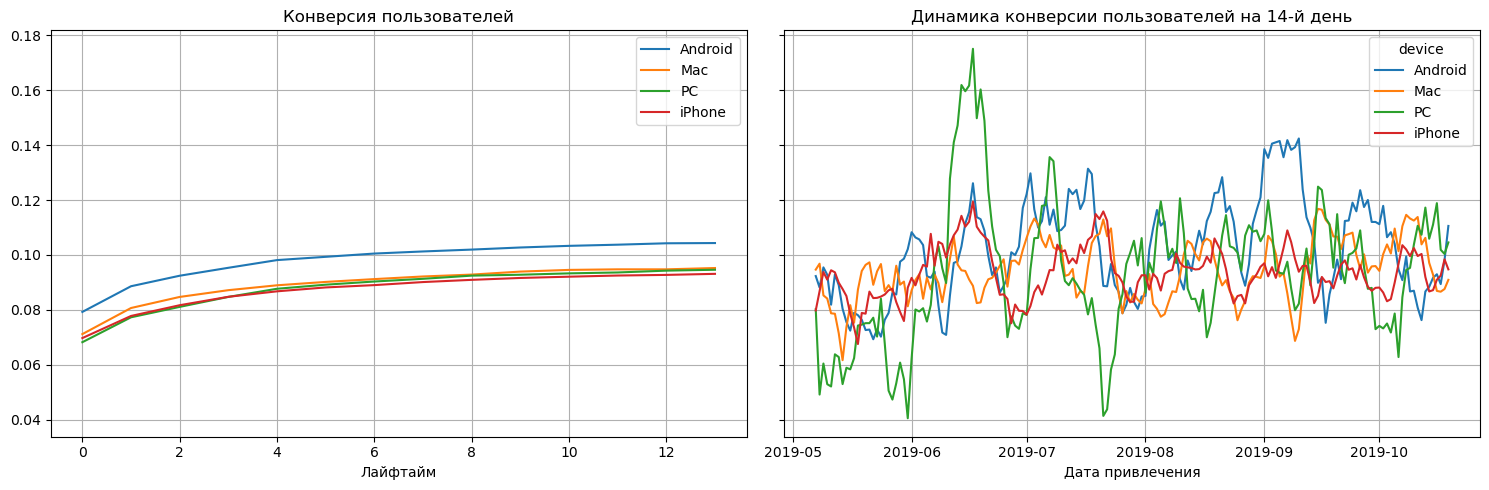

In [71]:
# конверсия в США с разбивкой по устройствам
conversion_raw_usa, conversion_grouped_usa, conversion_history_usa = get_conversion(
    profiles_usa, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped_usa, conversion_history_usa, horizon_days) 

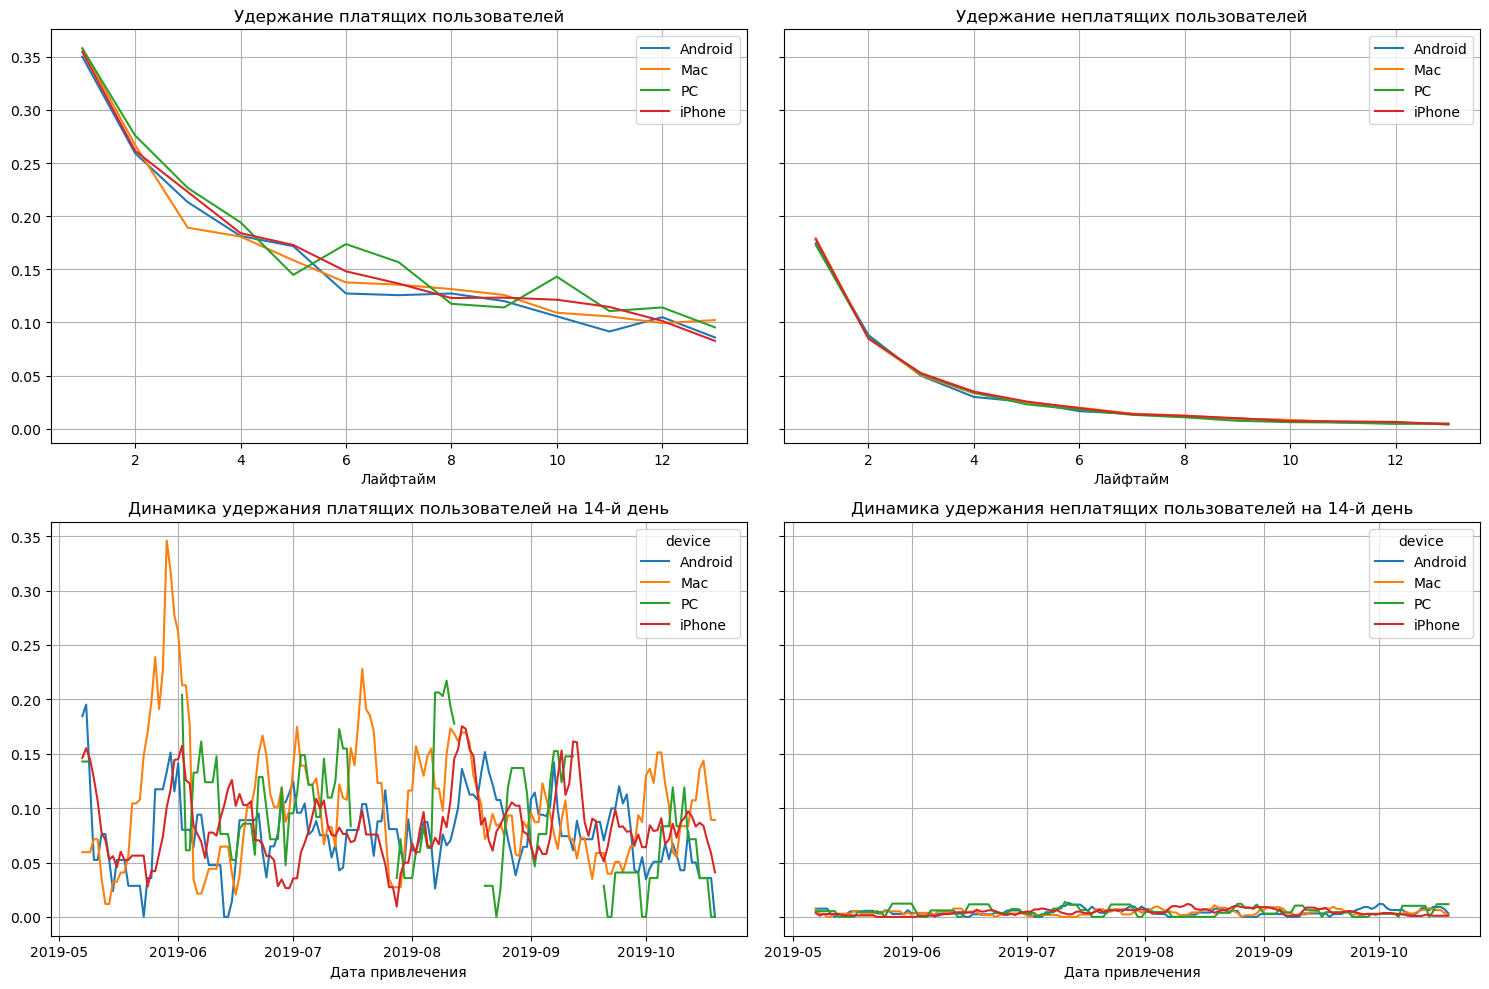

In [72]:
# удержание в США с разбивкой по устройствам
retention_raw_usa, retention_grouped_usa, retention_history_usa = get_retention(
    profiles_usa, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped_usa, retention_history_usa, horizon_days) 

**Вывод:**
- В США реклама не окупается.
- Стоимость привлечения резко выросла в июне для пользователей всех устройств.
- Чуть лучше выглядят пользователи `Android` - LTV и конверсия выше остальных.
- Удержание всех устройств находится на одном уровне.

#### С разбивкой по рекламным каналам

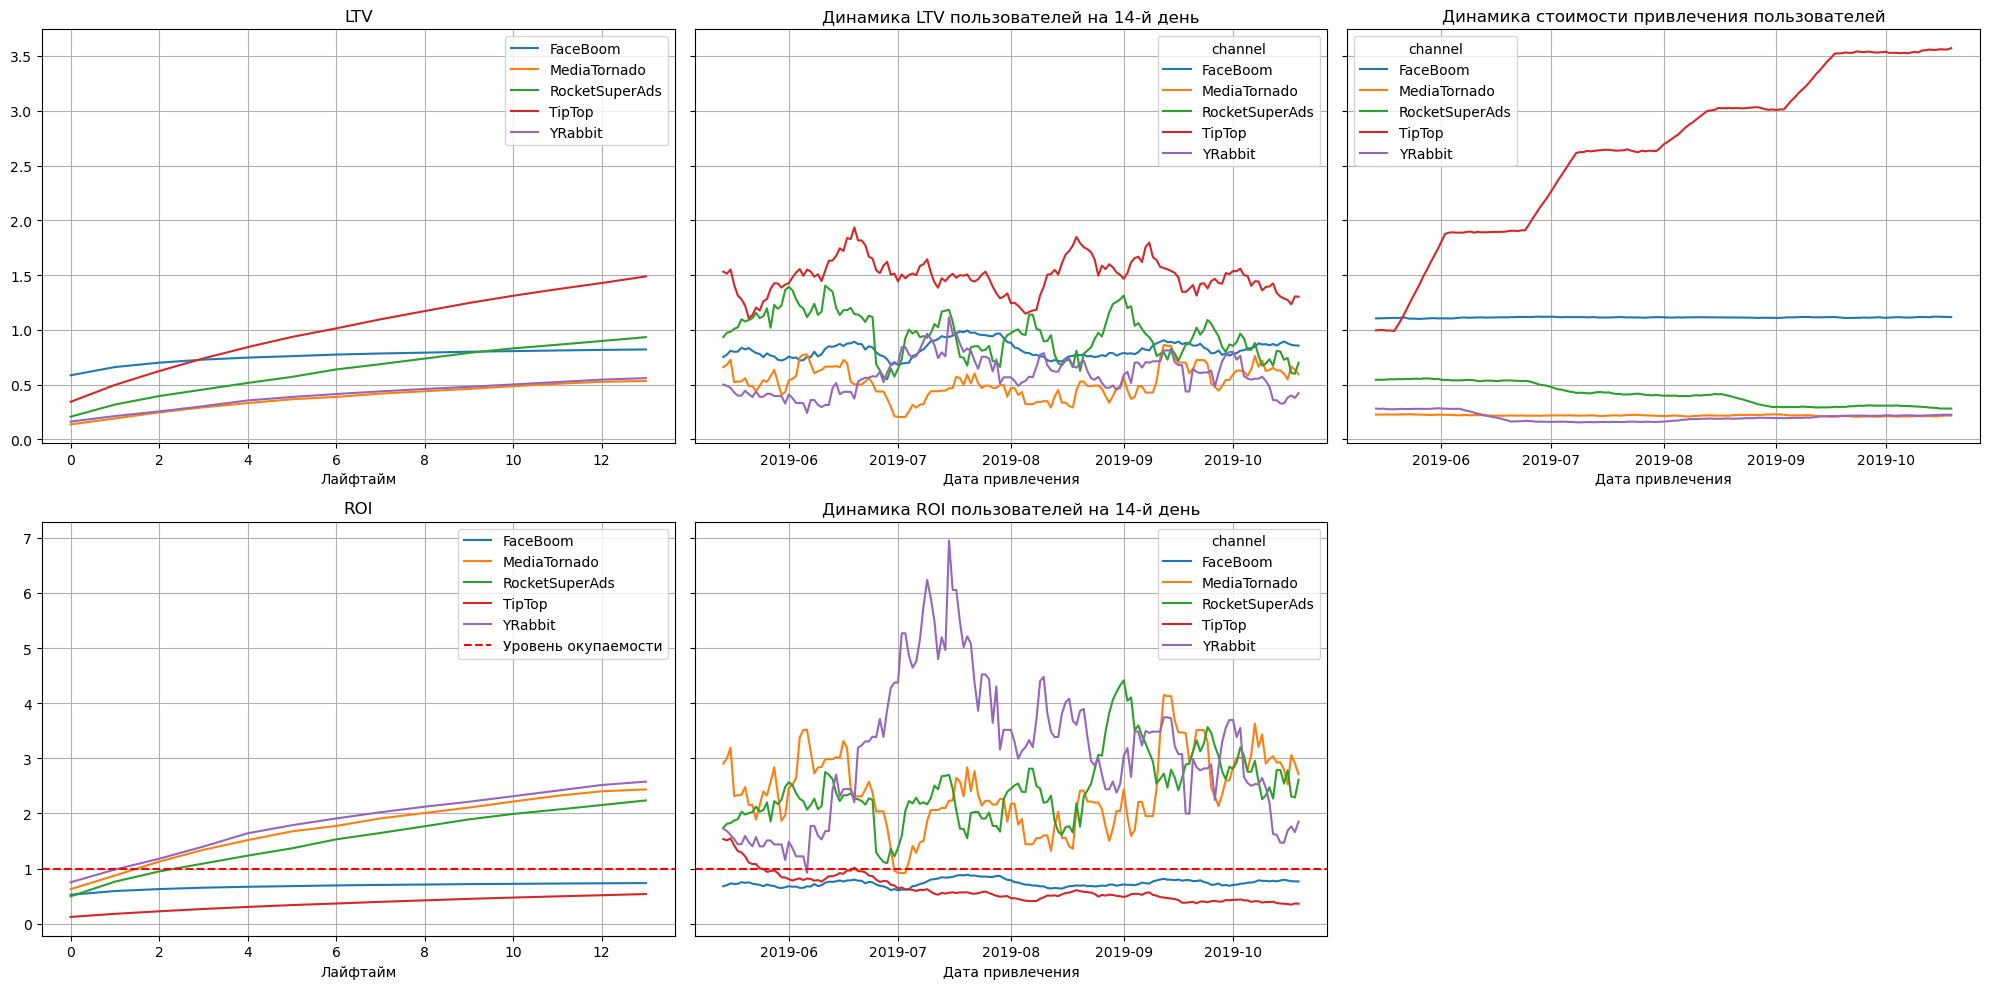

In [73]:
# окупаемость в США с разбивкой по рекламным каналам
dimensions = ['channel']

ltv_raw_usa, ltv_grouped_usa, ltv_history_usa, roi_grouped_usa, roi_history_usa = get_ltv(
    profiles_usa, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(ltv_grouped_usa, ltv_history_usa, roi_grouped_usa, roi_history_usa, horizon_days, window=14)

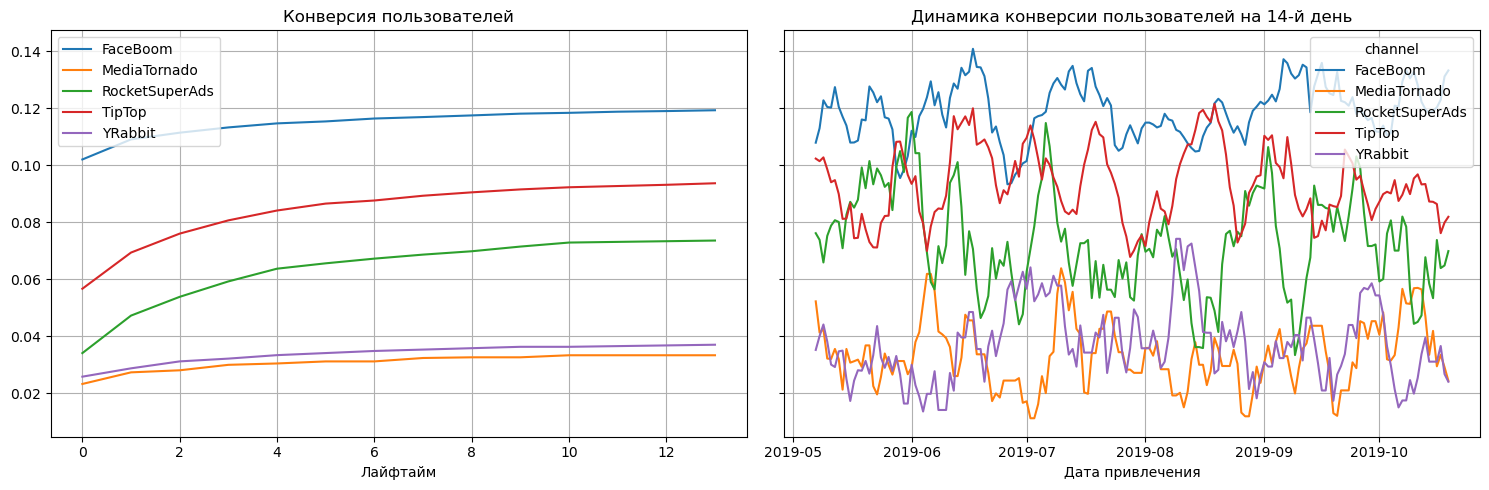

In [74]:
# конверсия в США с разбивкой по рекламным каналам
conversion_raw_usa, conversion_grouped_usa, conversion_history_usa = get_conversion(
    profiles_usa, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped_usa, conversion_history_usa, horizon_days) 

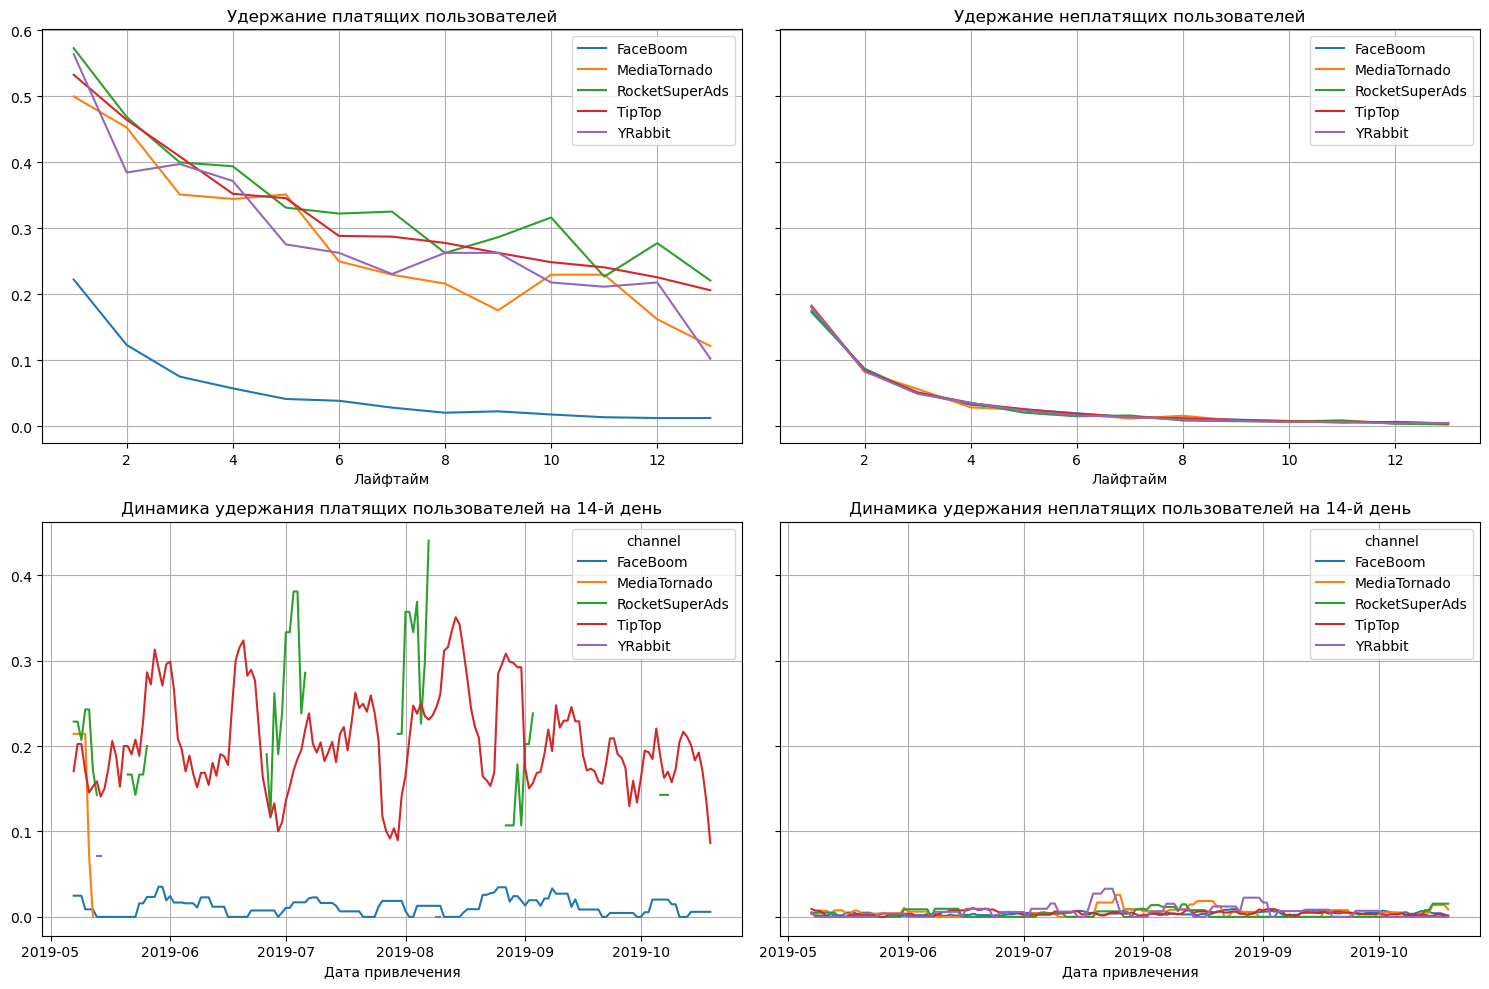

In [75]:
# удержание в США с разбивкой по рекламным каналам
retention_raw_usa, retention_grouped_usa, retention_history_usa = get_retention(
    profiles_usa, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped_usa, retention_history_usa, horizon_days) 

**Вывод:**
- Среди рекламных каналов в США выделяются каналы `TipTop` и `FaceBoom` - высокая стоимость привлечения, пользователи не окупаются за 14 дней.
- У канала `FaceBoom` низкая конверсия, другие каналы на одном уровне.
- Стоит обратить внимание на другие более стабильные каналы в США - `RocketSuperAds`, `MediaTornado`, `YRabbit`.

### Окупаемость рекламы в европейских странах

#### С разбивкой по странам

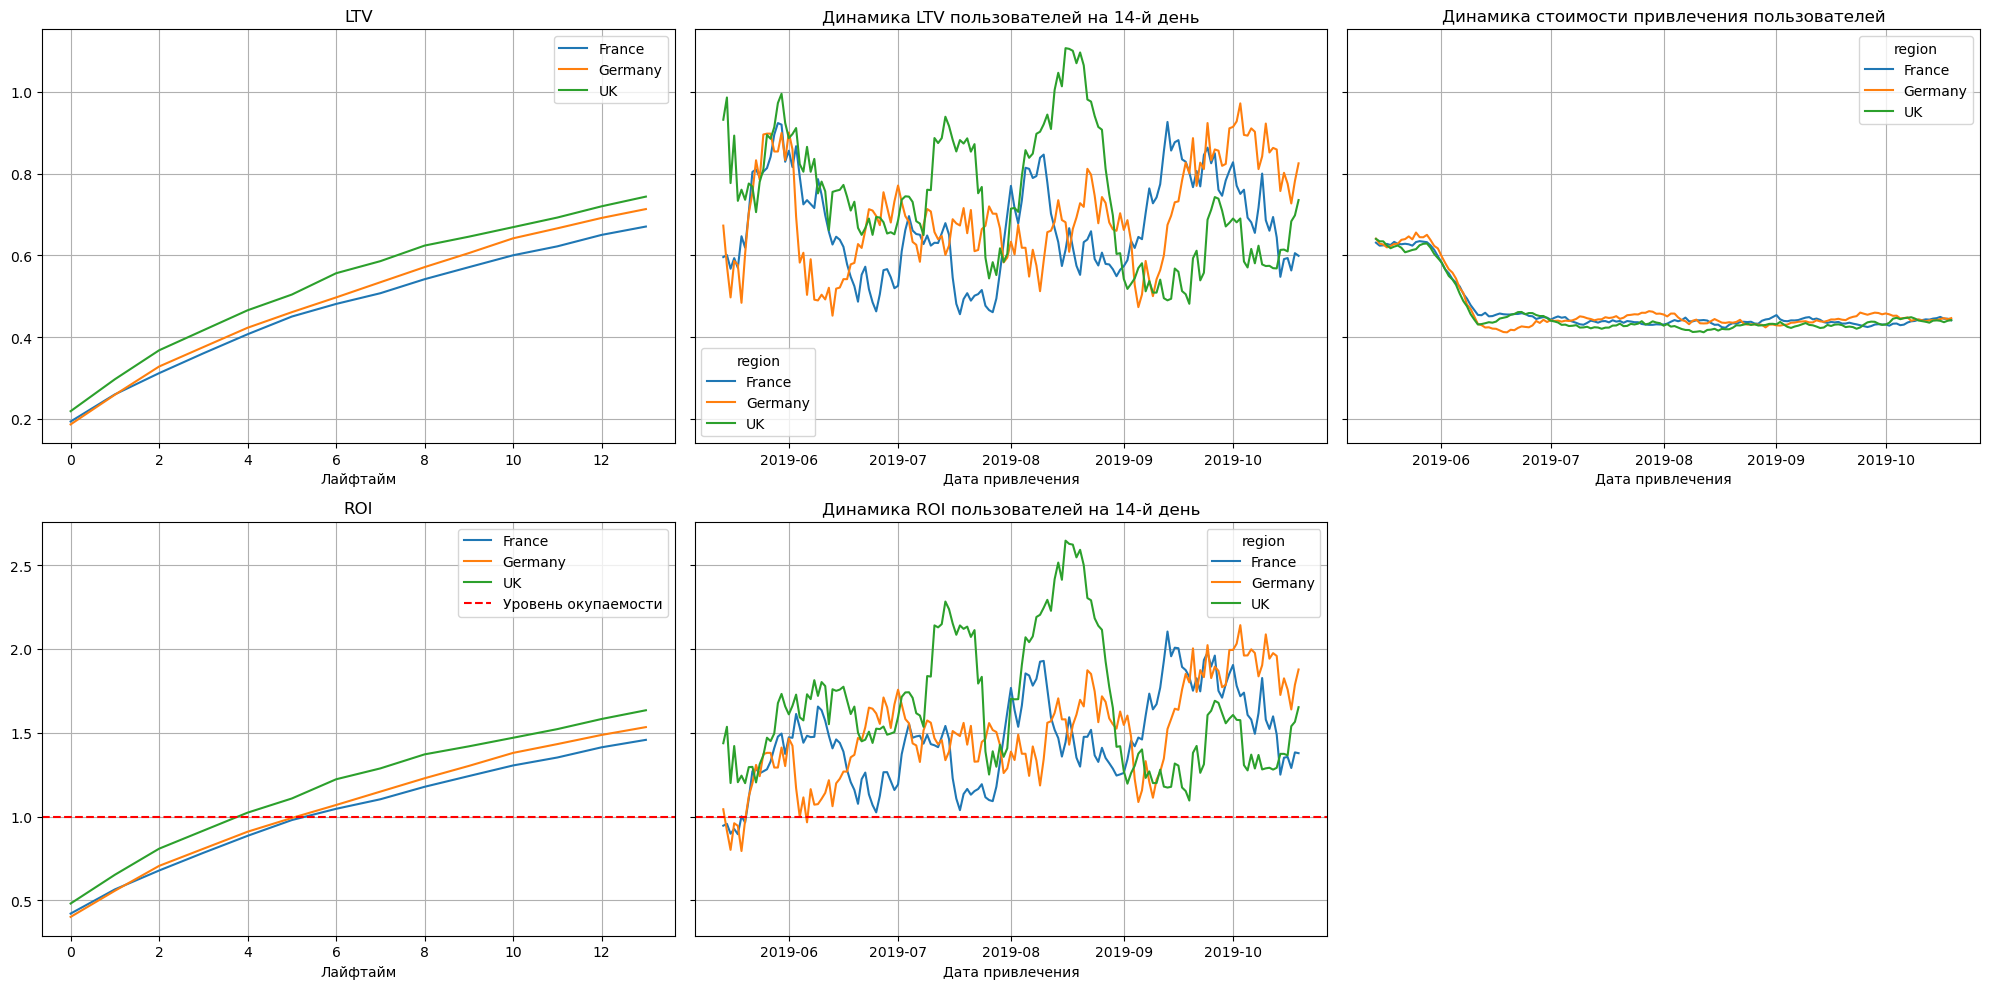

In [76]:
# окупаемость рекламы в Европе с разбивкой по странам
dimensions = ['region']

ltv_raw_euro, ltv_grouped_euro, ltv_history_euro, roi_grouped_euro, roi_history_euro = get_ltv(
    profiles_euro, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(ltv_grouped_euro, ltv_history_euro, roi_grouped_euro, roi_history_euro, horizon_days, window=14)

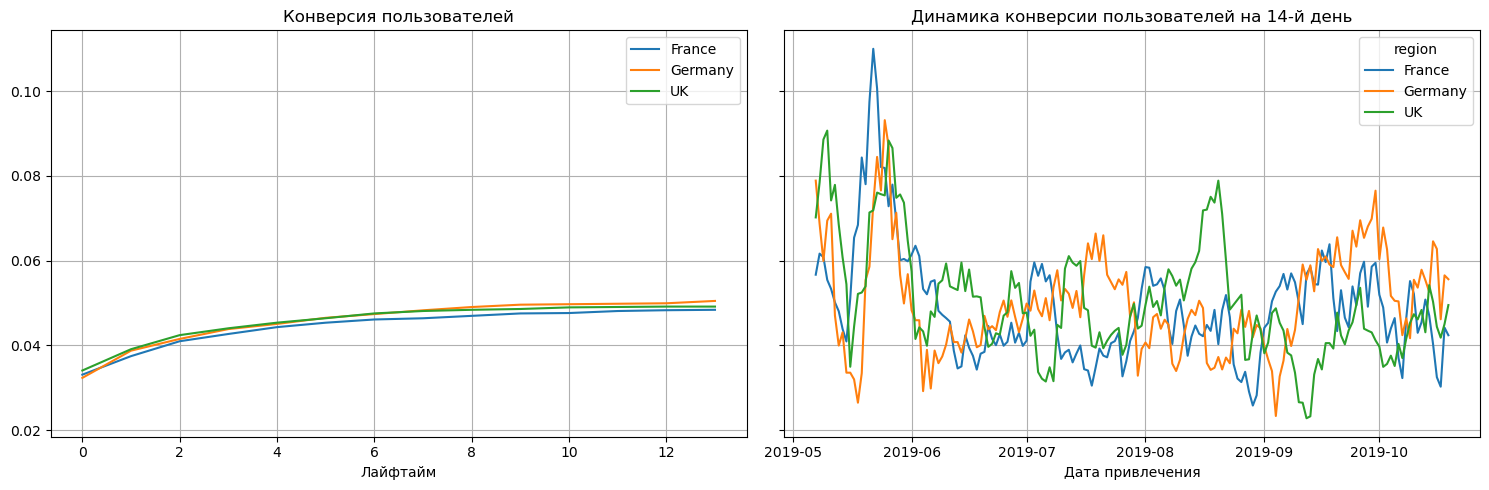

In [77]:
# конверсия в Европе с разбивкой по странам
conversion_raw_euro, conversion_grouped_euro, conversion_history_euro = get_conversion(
    profiles_euro, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped_euro, conversion_history_euro, horizon_days) 

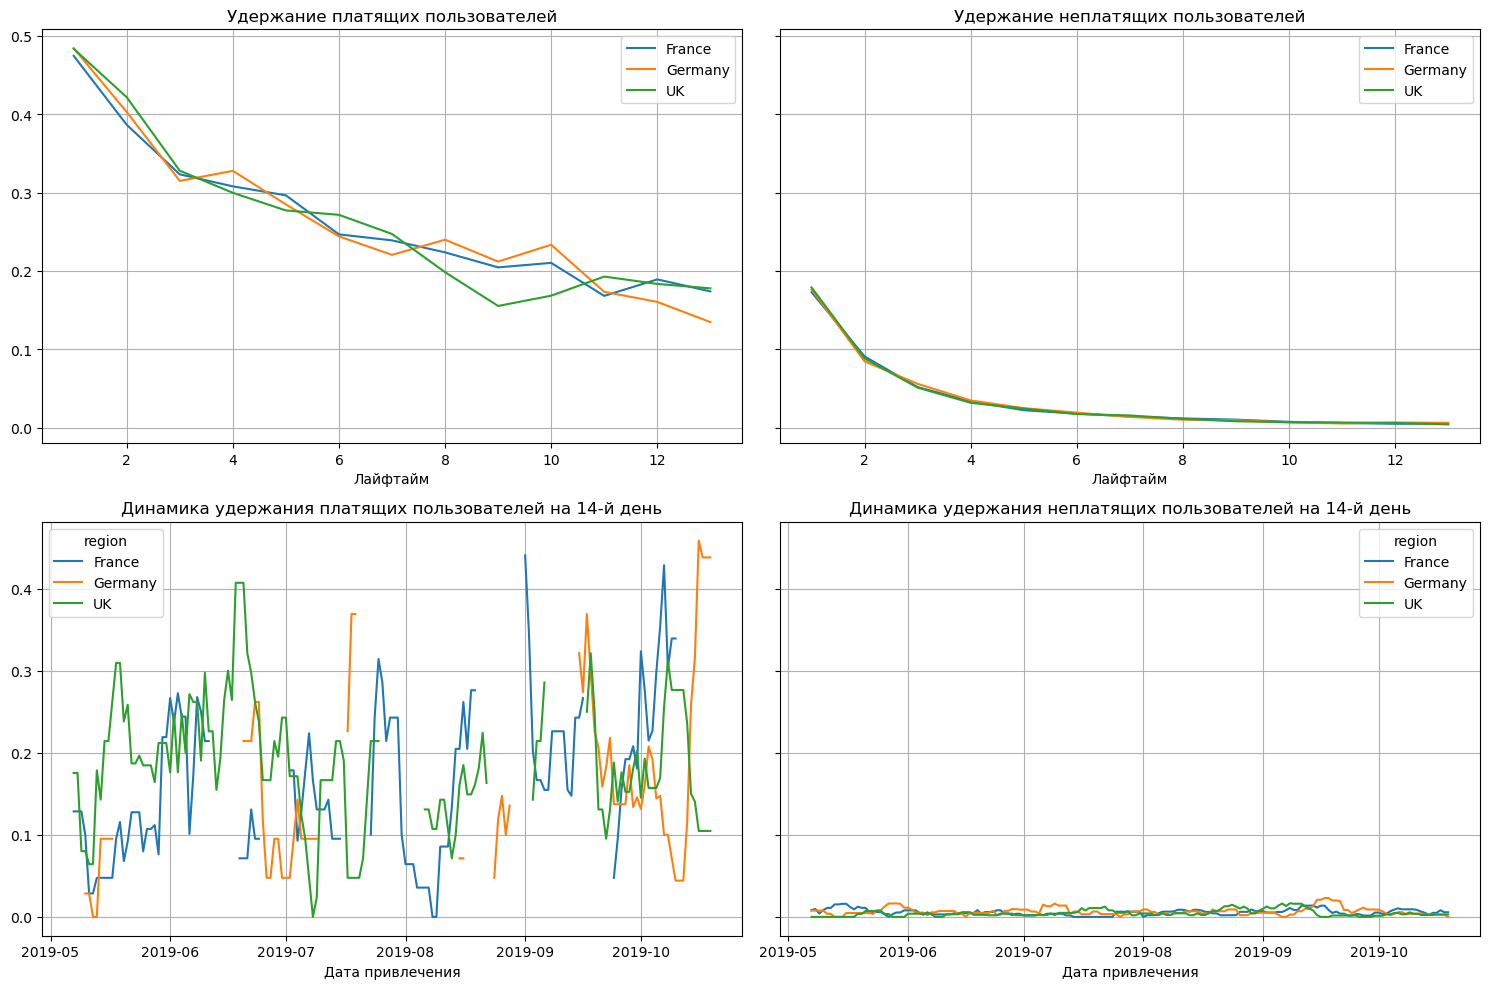

In [78]:
# удержание в Европе с разбивкой по странам
retention_raw_euro, retention_grouped_euro, retention_history_euro = get_retention(
    profiles_euro, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped_euro, retention_history_euro, horizon_days) 

**Вывод:**
- Реклама в Европе окупается.
- Стоимость привлечение в июне снизилась и стабильно держится на уровне 0.45.
- Великобритания окупается за 4 дня, Франция и Германия за 5 дней.
- У всех стран стабильные конверсия и удержание.

#### С разбивкой по устройствам

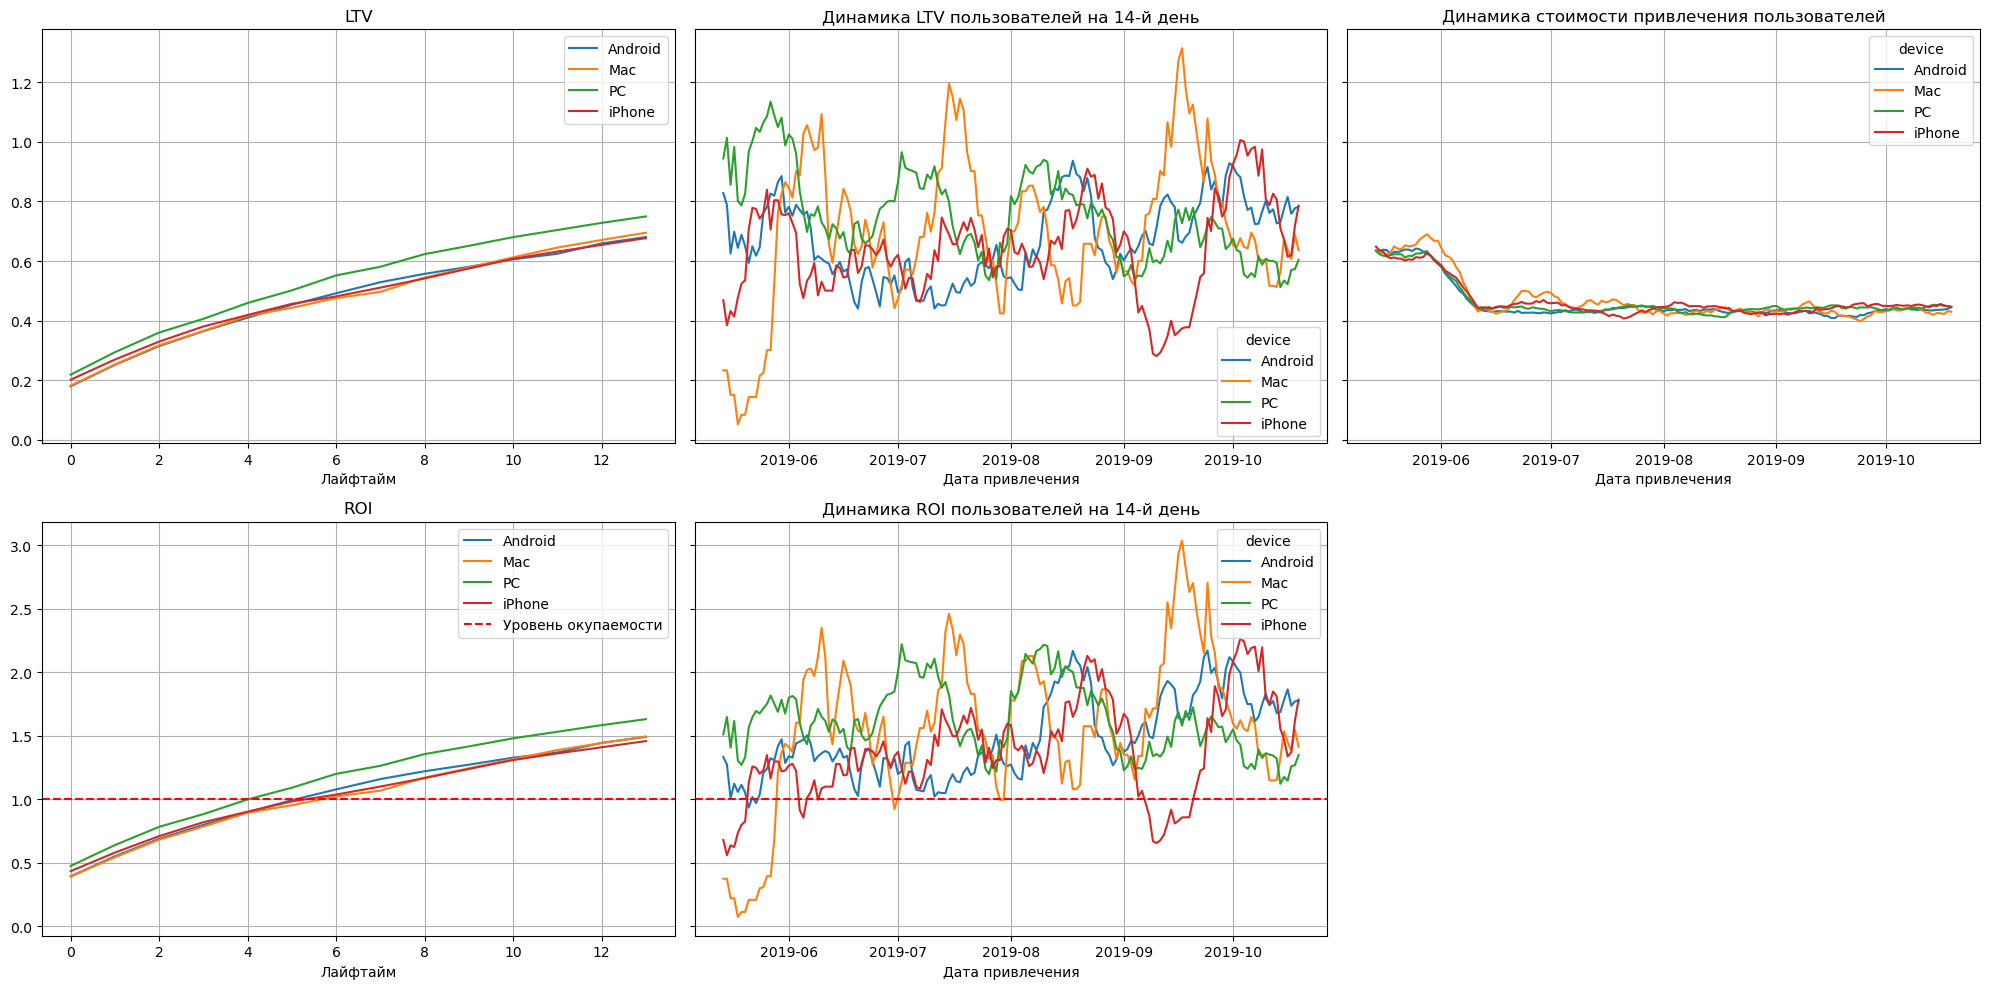

In [79]:
# окупаемость рекламы в Европе с разбивкой по устройствам
dimensions = ['device']

ltv_raw_euro, ltv_grouped_euro, ltv_history_euro, roi_grouped_euro, roi_history_euro = get_ltv(
    profiles_euro, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(ltv_grouped_euro, ltv_history_euro, roi_grouped_euro, roi_history_euro, horizon_days, window=14)

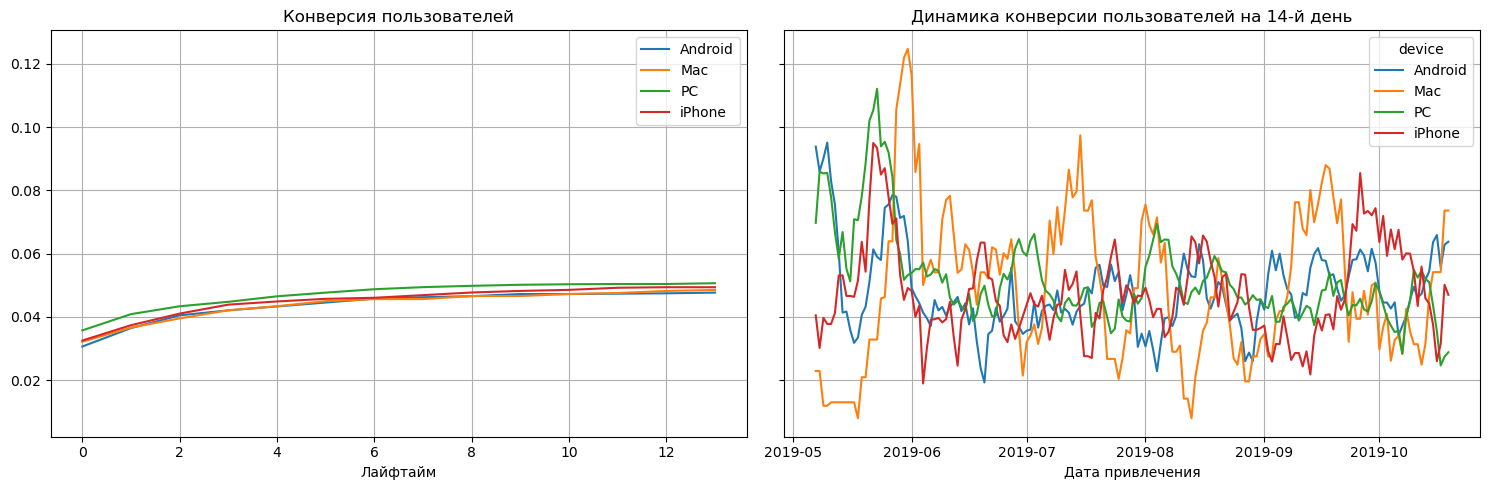

In [80]:
# конверсия в Европе с разбивкой по устройствам
conversion_raw_euro, conversion_grouped_euro, conversion_history_euro = get_conversion(
    profiles_euro, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped_euro, conversion_history_euro, horizon_days) 

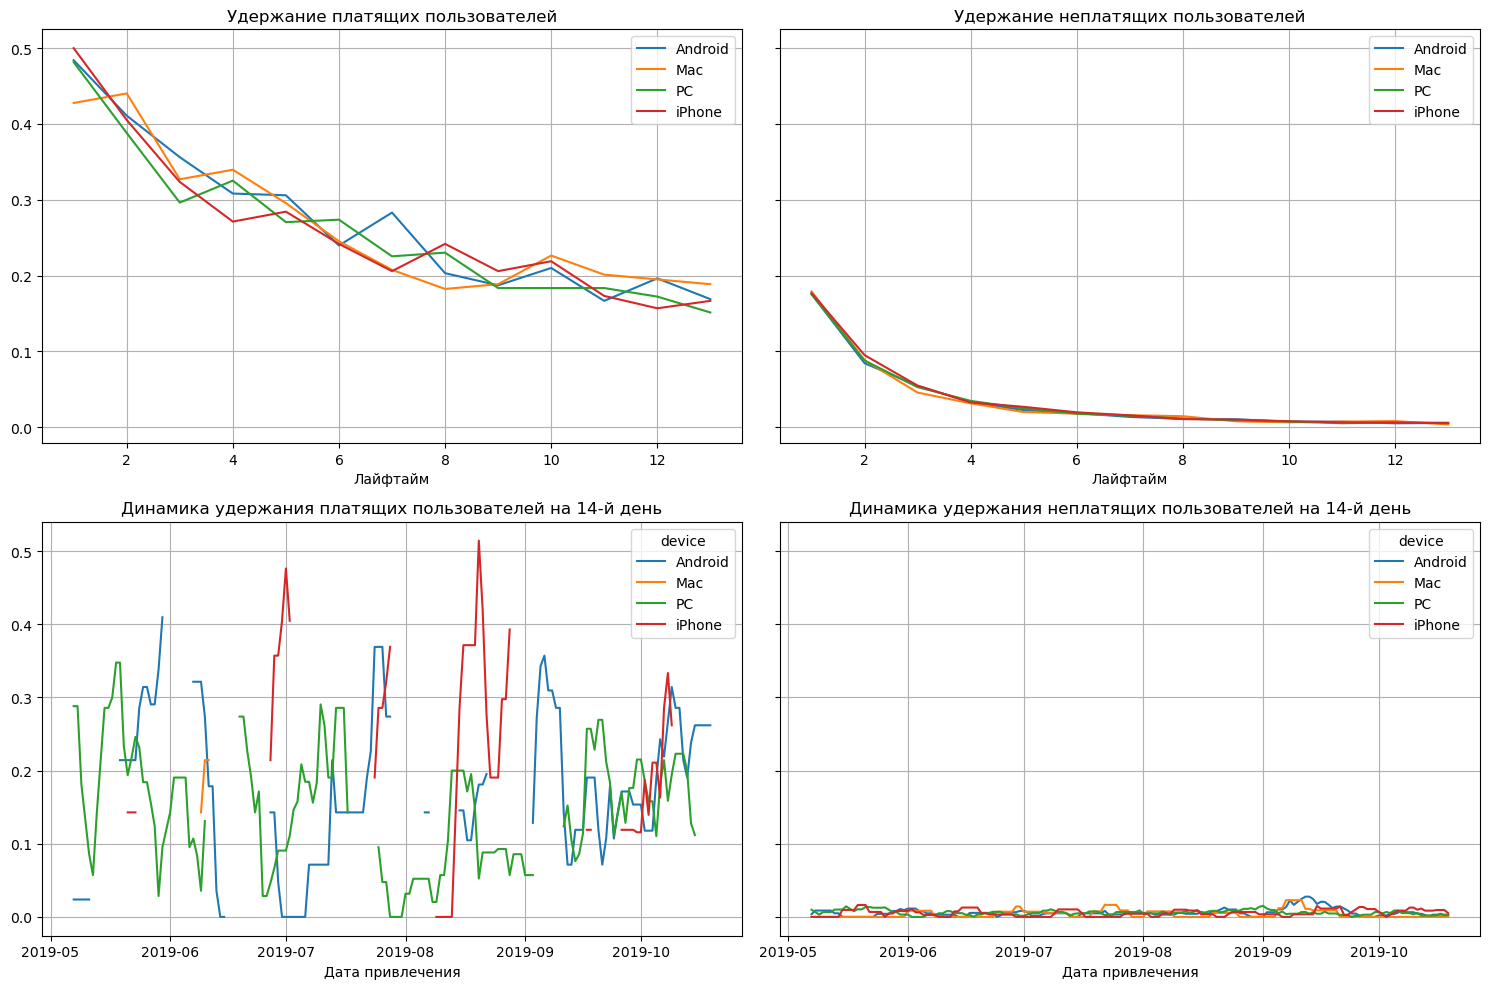

In [81]:
# удержание в Европе с разбивкой по устройствам
retention_raw_euro, retention_grouped_euro, retention_history_euro = get_retention(
    profiles_euro, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped_euro, retention_history_euro, horizon_days) 

**Вывод:**
- В разбивке по устройствам картина такая же стабильная.
- Чуть лучше выглядит окупаемость пользователей `PC`.

#### С разбивкой по рекламным каналам

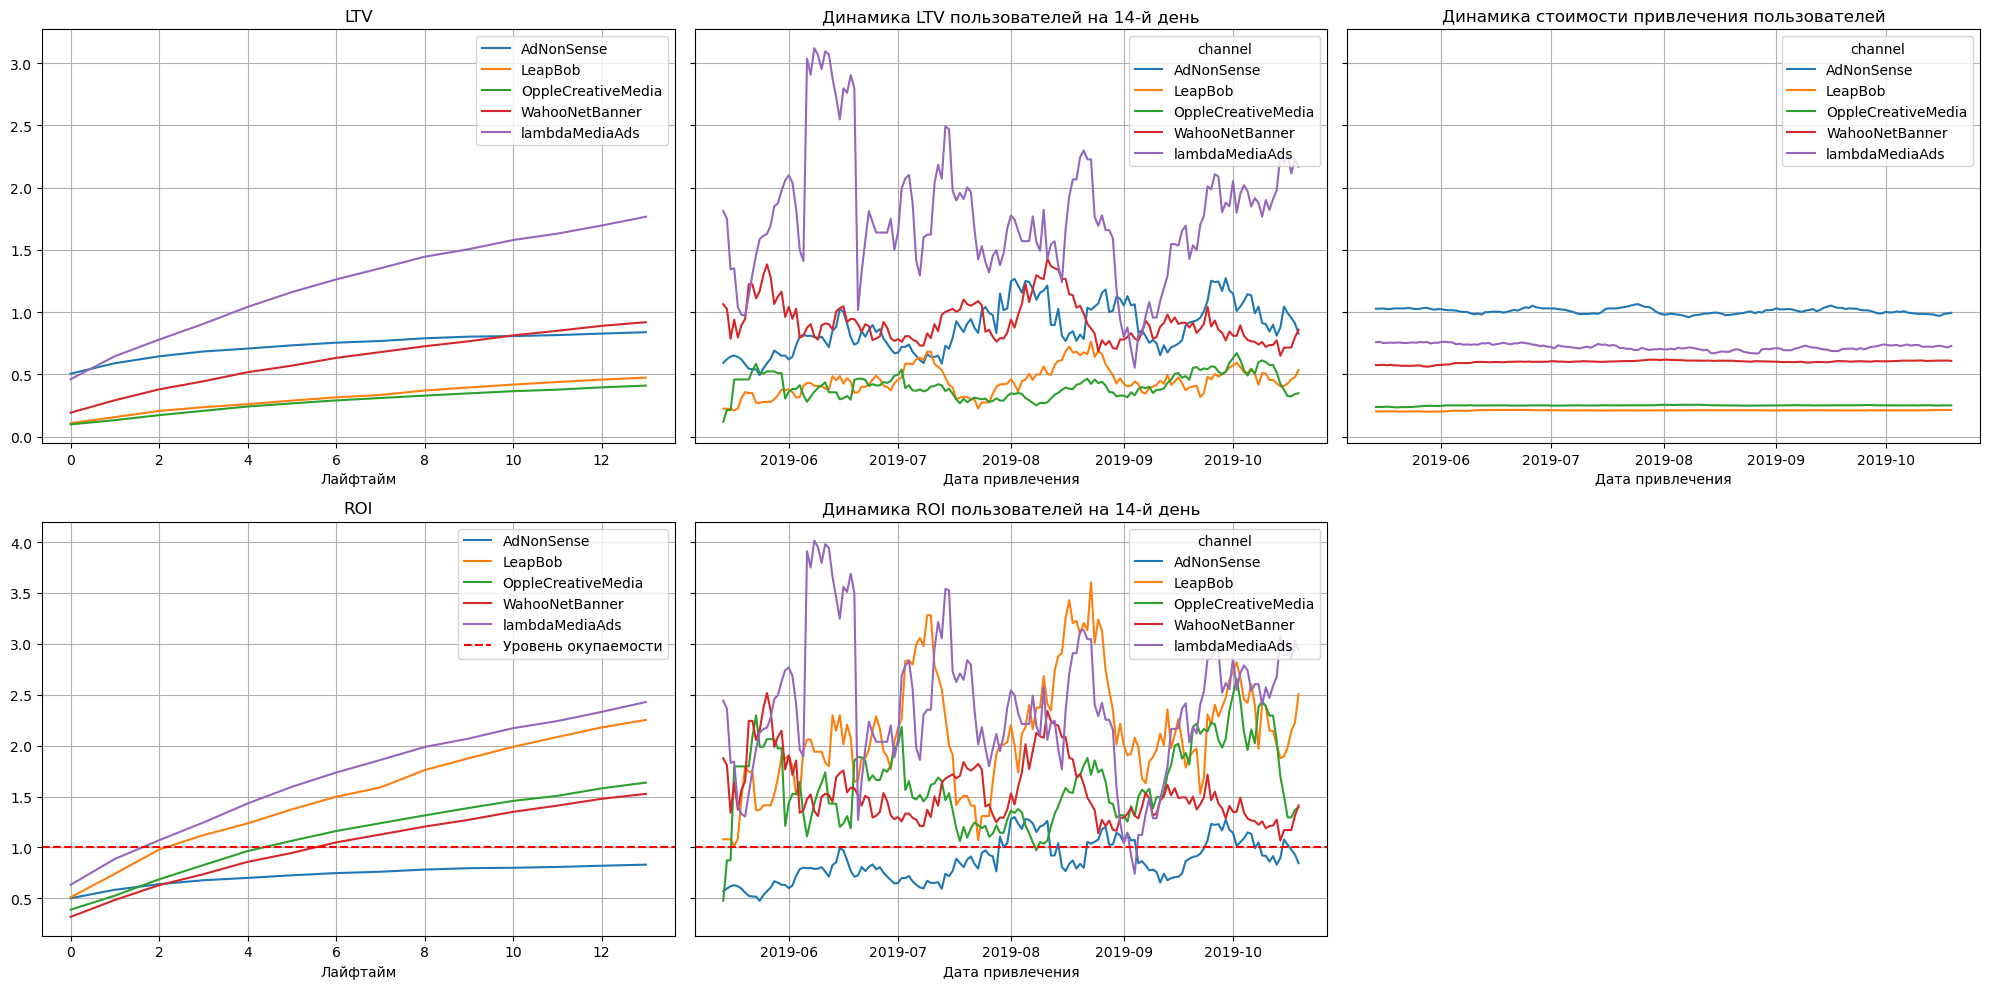

In [82]:
# окупаемость рекламы в Европе с разбивкой по рекламным каналам
dimensions = ['channel']

ltv_raw_euro, ltv_grouped_euro, ltv_history_euro, roi_grouped_euro, roi_history_euro = get_ltv(
    profiles_euro, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(ltv_grouped_euro, ltv_history_euro, roi_grouped_euro, roi_history_euro, horizon_days, window=14)

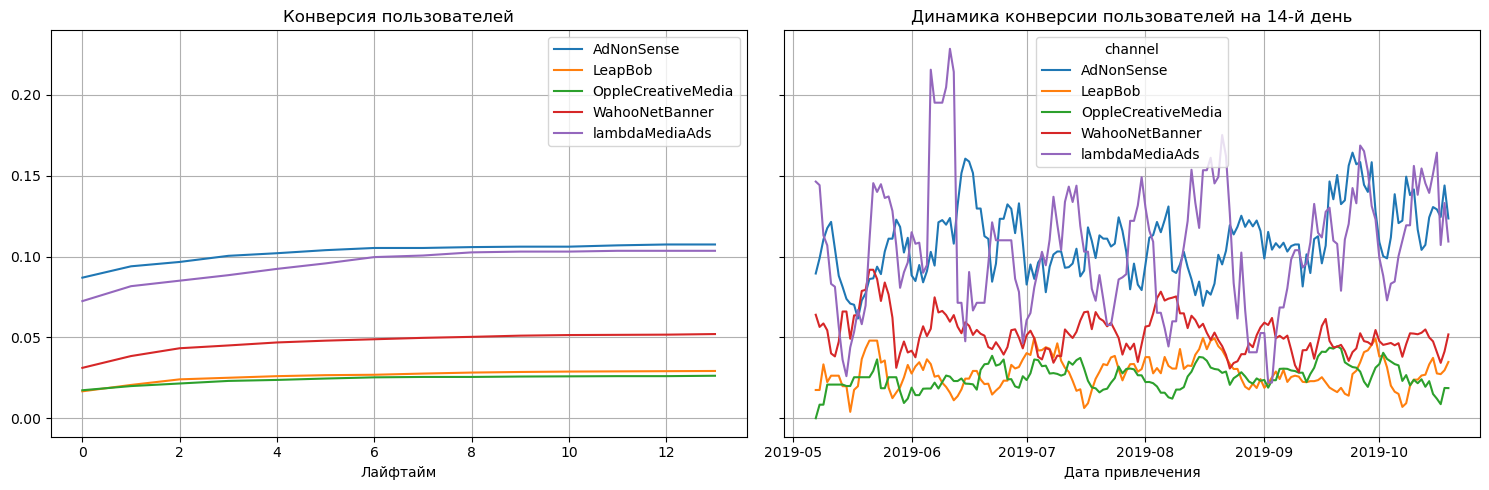

In [83]:
# конверсия в Европе с разбивкой по рекламным каналам
conversion_raw_euro, conversion_grouped_euro, conversion_history_euro = get_conversion(
    profiles_euro, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped_euro, conversion_history_euro, horizon_days) 

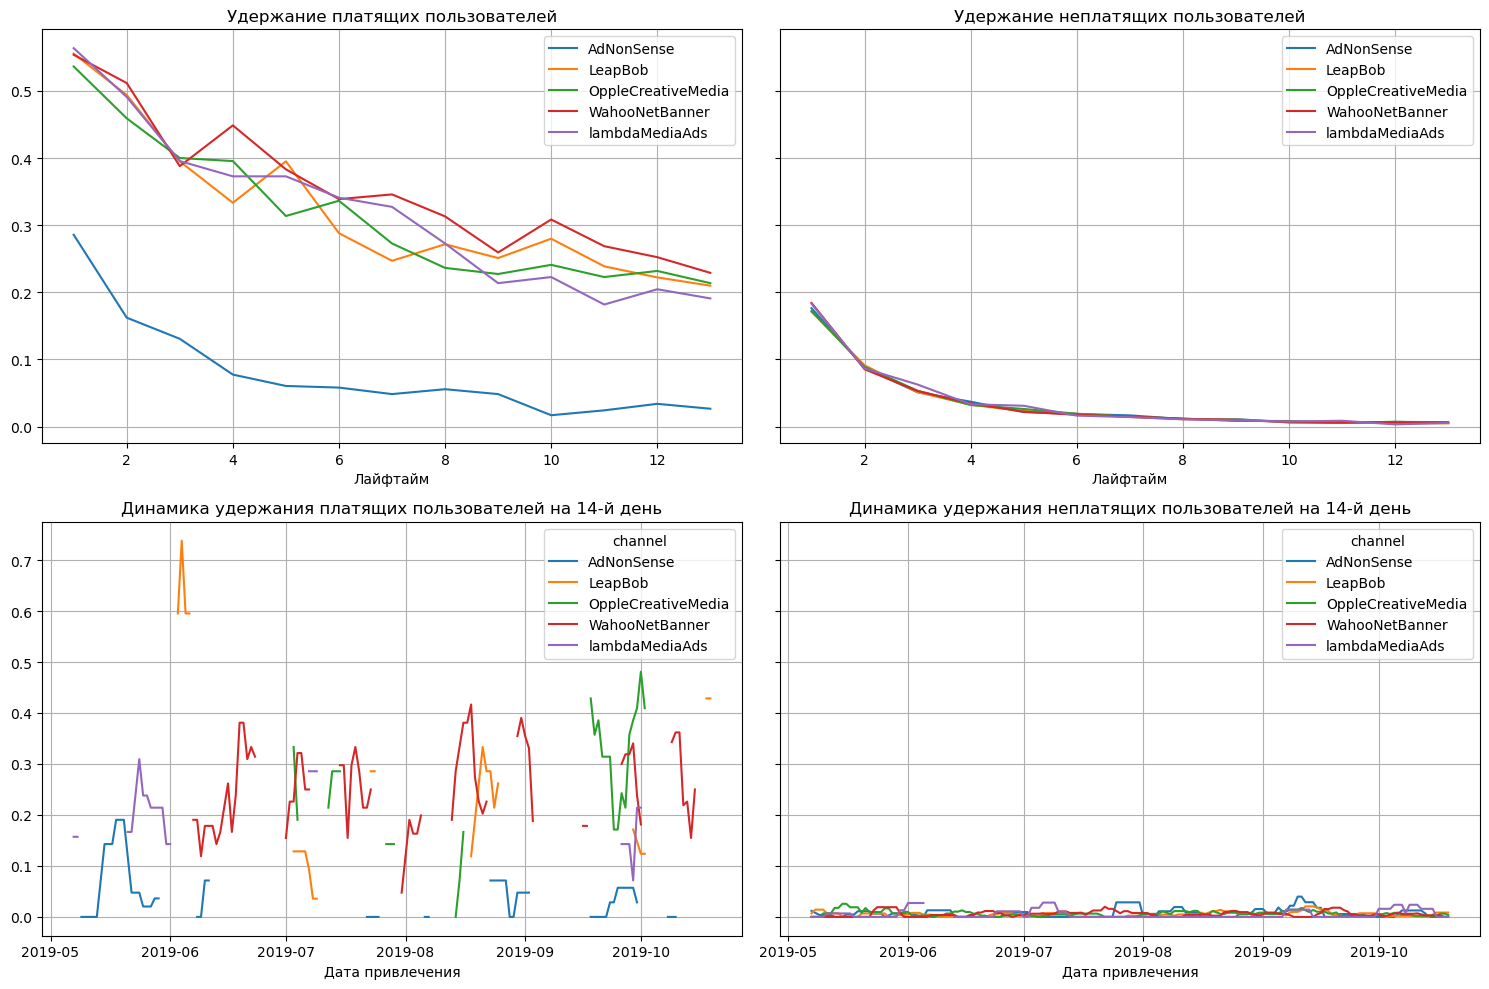

In [84]:
# удержание в Европе с разбивкой по рекламным каналам
retention_raw_euro, retention_grouped_euro, retention_history_euro = get_retention(
    profiles_euro, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped_euro, retention_history_euro, horizon_days) 

**Вывод:**
- Не окупается канал `AdNonSense` - самая высокая стоимость привлечения. Также очень низкое удержание.
- Остальные каналы окупаются за 2-6 дней.
- `lambdaMediaAds` имеет быструю окупаемость, стабильную конверсию и удержание - лидер из всех каналов в Европе.

**Вывод:**
- 

Причины неэффективности привлечения пользователей:
- Ставка на рынок США - бОльшая часть пользователей находится в этом регионе, но этот регион - самый убыточный.
- Привлечение пользователей из США через рекламные каналы `TipTop` и `FaceBoom` - высокая стоимость привлечения, низкое удержание, отсюда неокупаемость.
- Привлечение пользователей из Европы через рекламный канал `AdNonSense` - высокая стоимость привлечения и низкая конверсия в платящих пользователей.

На основе проведённого исследования можно дать следующие рекомендации по изменению маркетинговой стратегии:
- Для привлечения пользователей из США обратить внимание на рекламные каналы `RocketSuperAds`, `MediaTornado`, `YRabbit`. У них стабильные показатели и быстрая окупаемость.
- Для привлечения пользователей из Европы обратить внимание на рекламный канал `lambdaMediaAds`. У него стабильные показатели и быстрая окупаемость.
- Сильных различий в разбивке по устройствам не выявлено. Для США чуть лучше выглядят пользователи `Android`, для Европы - пользователи `PC`.